In [ ]:
### EjectaCompositionLateAccretion.ipynb
### Script to plot composition histograms as scaled pie charts and compare compositions
###


import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
from importlib import reload
import numpy as npy
from matplotlib import rc
import matplotlib.colors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker
import pkdgrav_ss as pkd
import os
import copy
import math
from scipy import optimize
import ipywidgets as widgets
from IPython.display import display
import time

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

rc('font',size=11)
rc('axes',titlesize=14)
rc('axes',labelsize=12)
rc('xtick',labelsize=11)
rc('ytick',labelsize=11)

mearth = 1./330060.

pn  = 2  #3, 2   # protoplanet to highlight
pnc = 0  # protoplanet to highlight - calm sim
maxnumf = 6000 #6000  #500,160 #40,200,2000   # max number of output steps
nsim = 13  # number of similar planetesimals to extract
core = False  # plot separate core compositions?

g = 1  # number of giant planets
getcore = True  # load core data?

hmax = 0.15  #0.2,0.5  # maximum for inset histograms


# set limits for full color scale
colbins = 25
mincol = 0.5
maxcol = 3.0

rscale = 5.7e5  #3.e4 # scaling factor for planet pies


path = 'data/'
loc = path + '022GTJf6hgas/' #'/cfGTruns/022GTJf6hydrogas/'
#loc = path + '/cfGTlow/022GTJf6nogas/'
#loc = path + '/cfGTlow/022GTJf6hydrogas_2/'
#loc = path + '/cfGTlow/035GTJf6hydrogas/'
#loc = path + '/cfGTlow/022GTJf6latehg/'
#loc = path + '/cfGTlow/022GTJf6hydrogasf/'
#loc = path + '/cfGTruns/022GTJf6nogas/'
#loc = path + '/cfGTruns/022f6nogas/'

#loc = path + '/cfGTruns/022f6simpgas_4/'

loc_c = path + '022f6sgas_4/'
#loc_c = path + '/cfGTruns/022f6simpgas_3/'
#loc_c = path + '/cfGTlow/035f6nogas/'


collmod = True
rho = 2.  # planetesimal density (for size scale)
expfac = 6.  # expansion factor

cccut = 0.95  # correlation limit for very similar (combined fragment plot)

# Did Earth eat its leftovers? Impact ejecta as a component of the late veneer

Philip J. Carter & Sarah T. Stewart

*Submitted for publication in PSJ*

The presence of highly siderophile elements in Earth’s mantle indicates that a small percentage of Earth’s mass was delivered after the last giant impact in a stage of 'late accretion.' 
There is ongoing debate about the nature of late accreted material and the sizes of these bodies. Earth appears isotopically most similar to enstatite chondrites, and it has been suggested that late accretion must have been dominated by enstatite chondrite-like bodies that originated in the inner disk, rather than ordinary or carbonaceous chondrites. 
Here, we examine the compositions of 'leftover' planetesimals, present in the inner disk in the late stages of accretion simulations. Dynamically excited planet formation produces planets and embryos with similar compositions, suggesting that the Moon-forming impactor may have had a stable isotope composition very similar to the proto-Earth. Commonly, some planetesimal-sized bodies with similar compositions to the Earth-like planets are left at the end of the main stage of growth. The most chemically-similar planetesimals are typically fragments of proto-planets ejected millions of years earlier. If these similar-composition bodies are later accreted by the planet, they would represent late-accreted mass that naturally matches Earth's composition. The planetesimal-sized bodies that exist during the giant impact phase can have large core mass fractions, with core compositions similar to the proto-Earth. These bodies are an important potential source for highly siderophile elements. The range of core fractions in late accreted bodies complicates simple inferences based on the highly siderophile elements in the mantle.

*planetesimals -- planet formation -- cosmochemistry -- impact phenomena -- Earth*


## Introduction

The formation of the terrestrial planets in our solar system is usually considered to occur in a number of distinct (though likely overlapping) phases: planetesimal formation, runaway growth, oligarchic growth, and culminating in the chaotic giant impact phase. It is generally accepted that the last major accretion event on the Earth – the last giant impact – was the event that led to the formation of the Moon. The Moon-forming impact is, however, not the true end to accretion; indeed, some accretion continues to this day. 

Siderophile ('iron-loving') elements provide key insights into the properties of the growing Earth and the compositional characteristics of accreted bodies. Siderophile elements were variably removed from the mantle of the growing Earth by metal-silicate equilibration during episodes of core formation, and possibly via sulphide segregation \citep[e.g.][]{Rubie16}. The higher-than-expected abundances and chondritic proportions of highly siderophile elements (HSEs) in the Earth’s mantle suggests that a small percentage of the Earth's mass was delivered after the last giant impact in a stage of late accretion, also referred to as the 'late veneer' \citep[e.g.][]{Walker09,Mann12}.

There is substantial debate about the nature of this late accreted material \citep[e.g.][]{Bermingham18,Hopp20}, and the sizes of the bodies that delivered it \citep[e.g.][]{Bottke10,Schlichting12,Brasser20}. The late veneer has commonly been associated with the idea of delivery of volatile elements and compounds to the Earth, usually via 'wet', carbonaceous-chondrite-like or cometary bodies. It has, however, been shown that most of Earth's water likely arrived before the Moon-forming impact \citep{Halliday13,Dauphas13,Greenwood18}. Earth appears isotopically most similar to the enstatite chondrite family, and it has been suggested that late accretion must also have been dominated by enstatite-like material \citep{Dauphas17,Bermingham18}, rather than carbonaceous chondrites. The origin of late accreted bodies is unknown, but the lack of a substantial outer solar system chemical signature in the silicate Earth suggests that most late-accreted mass originated in the inner disk \citep[e.g.][]{Marty17}. Recent work by \citet{Fischer-Godde20} and \citet{Hopp20} suggests that late accretion consisted of a mixture of bodies including carbonaceous-chondrite-like material and mass from an inner solar system reservoir not present in the meteorite record.

Since the HSEs measured in the Earth are in chondritic proportions, it has generally been assumed that they were delivered by bodies of primordial composition. However, there is no requirement that these were undifferentiated, chondrite-like bodies. Chondrite parent bodies (or, at least, the unmelted outer layers of bodies from which chondrites may have originated) form after the first generation of planetesimals, once planet growth has already begun \citep[e.g.][]{Dauphas11, Kruijer14}. If the late veneer consisted of differentiated planetesimals, or even small embryos \citep[e.g.][]{Raymond13,Genda17}, it is likely that at least some portion of the impactor's metallic cores would be delivered to the Earth's mantle, rather than sinking to the core. Thus, the late veneer need not consist of undifferentiated bodies, as long as their HSEs remain in approximately chondritic proportions overall.

One expected source of late veneer impactors is the population of planetesimals (or planetesimal-sized bodies) left in the inner solar system at the end of the main stages of accretion \citep[e.g.][]{Schlichting12}. In planet formation simulations, a number of planetesimal impacts occur at late times, after the final embryo-embryo giant impacts. In $N$-body simulations these planetesimals are typically assumed to be primordial, and their properties have not been examined closely. These bodies may, however, have undergone significant collisional processing during the main stages of accretion, or represent fragments ejected from other collisionally evolved bodies \citep[e.g.][]{Genda17_GIFs}.

Here, we examine the compositions of these 'leftover’ planetesimals, present in the inner disk in the late stages of accretion simulations. Dynamically excited planet formation can result in terrestrial planets, embryos and planetesimals with similar compositions. We examine and quantify this similarity, and investigate the origins and evolution of these compositionally similar planetary bodies. The simulations discussed in this work evolve the protoplanetary disk through the runaway and oligarchic growth phases, but end before the conclusion of the giant impact stage of terrestrial planet formation. The properties of planetesimals and other planetary bodies at the end of these simulations could be considered representative of the compositions of bodies in 'classical' $N$-body simulations of the giant impact stage of planet formation.

## Numerical methods

The simulations discussed in this work were carried out using a modified version of the PKDGRAV $N$-body code \citep{Richardson00,Stadel01}. This code includes gravitational interactions between planetesimals (using a gravity tree), aerodynamic drag from the nebular gas, and planetesimal--planetesimal collisions. This version of PKDGRAV also includes the detailed empirically derived analytical collision model (EDACM) from \citet{Leinhardt12} and \citet{Leinhardt15}. EDACM provides realistic outcomes for collisions between planetesimals in the gravity-dominated regime. 

Most of the simulations discussed in this work were previously described in \citet{Carter15}. We examine two dynamically contrasting scenarios: 'calm accretion' – with no giant planet perturbations, and the 'Grand Tack' model – in which Jupiter migrates inward through the protoplanetary disk and then back out towards its modern orbit. The migration began 2\,Myr after the start of the simulations. In both cases, simulations began with either 10\,000 or 100\,000 self-gravitating planetesimals distributed to produce a solid surface density comparable to the minimum mass solar nebula (MMSN) on 'cold', near-circular orbits around a one solar mass star. These planetesimals have radii greater than 100\,km and are therefore assumed to be differentiated into an iron core and silicate mantle from the start of the simulations.

These simulations used radius enhancement to increase the collisional cross-section and speed up the evolution \citep[see][for further discussion]{Kokubo+Ida02,Carter15}. With particle radii enhanced by a factor of 6, the 600\,000\,year integration time represents an effective duration of $\sim$21\,Myr. Thus, the simulations evolve the protoplanetary disk through the runaway and oligarchic growth phases, but end before the conclusion of the giant impact stage of terrestrial planet formation. The properties of planetesimals and other planetary bodies at the end of these simulations could be considered representative of the compositions of bodies in typical simulations of the giant impact phase of planet formation \citep[e.g.][]{Chambers01,Walsh11}. The effective times should not be considered to be precise; however, this imprecision is not important for the outcomes of collisions or the compositional evolution that occurs during accretion.

The collision model, EDACM, calculates the size and velocity distribution of post-collision remnants and fragments from the standard collision parameters: impact angle, mass ratio, and impact velocity \citep[see][]{Leinhardt12,Stewart12,Leinhardt15}. When using a collision model that can produce fragments in an $N$-body code it is necessary to prevent production of increasing numbers of small fragment particles, usually by imposing a mass limit on fragments. Several authors have placed any remaining fragment mass back onto the largest post-collision remnant, or distributed this mass between a small number of fragments \citep[e.g.][]{Chambers13}. In PKDGRAV, mass assigned to fragments that would fall below this mass (or resolution) limit, $M_\mathrm{min}$, is instead placed in a debris annulus corresponding to the location in the disk at which the collision occurred. This 'unresolved debris' is distributed in 0.1$\,$au wide annular bins throughout the modeled region of the disk. The unresolved debris consists of both 'core' and 'mantle' components. As well as being generated in collisions, the debris is re-accreted by resolved planetesimals on non-circular orbits passing through each annulus \citep{Leinhardt05,Carter15,Leinhardt15}. The small scale debris is thus recycled and the instantaneous mass in debris never grows to a large fraction of the total mass, even though a large fraction of the total mass is processed through this debris \citep{Bonsor15,Carter15,Davies20}.

After each collision, the core and mantle components of the impactors are distributed to post-collision remnants according to a mantle stripping law based on \citet{Marcus10}. The simulations discussed in this work used mantle stripping 'model 3' as defined in \citet{Carter15} as the average of the two models given by \citeauthor{Marcus10}. We note that the way core material was distributed to smaller post-collision remnants in these simulations -- assigning core mass first to 'fill' remnants in descending mass order -- may overproduce high core mass fraction bodies \citep[see][]{Carter18}. Core and mantle masses remain distinct throughout the simulations; we neglect chemical exchange and re-equilibration.

All bodies begin with a numerical composition based on the initial radial location of the mass they contain, corresponding to the same 0.1$\,$au wide annuli as the debris bins. 
This tracking scheme is motivated by the idea of radial gradients in the initial bulk and isotopic composition of solids in the disk. 
These compositions evolve any time a body experiences a collision or accretes debris. Unlike in most other $N$-body simulations, in this work, planetesimals can accrete both via collisions with other resolved bodies and via unresolved debris. Remnants and fragments of collisions are updated to have the mass-weighted average composition of the impactors (examples of these compositions are shown in Figure \ref{f:ccexample}).
This model does not include the formation of new planetesimals directly from dust or pebbles. 

The migration of Jupiter in the Grand Tack model is achieved by imposing an acceleration on the particle representing the giant planet. The planetesimals experience aerodynamic drag from the nebular gas based on the prescription of \citet{Adachi76}. The nebular gas surface density profile is based either on the MMSN, or a denser gas disk with gaps produced by the giant planets based on \citet{Morbi07} as used in several previous works \citep[e.g.][]{Walsh11,Raymond17,Carter15,CarterStewart20} – which we refer to in the rest of this work as the MC gas profile. 
After $\sim$2$\,$Myr (the time corresponding to giant planet migration), the nebula dispersed with an e-folding timescale, $\tau_\mathrm{gas}$, of 0.1$\,$Myr in most simulations.

A summary of the simulations discussed in this work is given in Table \ref{t:sims}. Further details on all aspects of the simulations can be found in \citet{Carter15}.

We extracted the composition histograms – arrays of mass fraction derived from each radial bin – for all bodies at regular intervals throughout the simulations. The compositions of the metallic cores of these differentiated bodies were also extracted. These compositions can be compared by calculating the Pearson correlation coefficient of the composition histograms of any pair of bodies. Examples of compositions and correlations are given in Figure \ref{f:ccexample}. A correlation coefficient of $+1$ indicates a perfect match in composition, the first row of Figure \ref{f:ccexample} shows a very close match with a coefficient of $+0.97$. Large negative values occur when most of the radial bins have substantially differing contributions between the two bodies, for example the final row in Figure \ref{f:ccexample} shows one embryo with substantial material from all but the first bin, and a second embryo that acquired the majority of it's mass from the first bin, thus leading to a correlation coefficient of $-0.32$. Perfect anti-correlation is very unlikely to occur. Note that the top left embryo in Figure \ref{f:ccexample} acquired most of its mass from yellow-colored bins interior to 0.8$\,$au, but its average color is orange – corresponding to $\sim$1.1$\,$au – due to the contribution of material from greater heliocentric distances.

Since we track each body's mass and composition throughout the simulation, we can thus determine how similar any planetesimal is to each embryo as a function of time. In this work we define embryos as bodies with masses of at least 1\% the mass of the Earth, and planetesimals as smaller bodies. There is no computational distinction between these size classes.

##### Configuration

In [2]:
# embryo mass cutoff
minembmass = 0.01*mearth  #.0246*mearth


##### Load data

In [3]:
# load final sim output

ssG = pkd.ss()
paramG = pkd.readparam(loc+'ss.par')
ssG.read(loc+'ss.{:0>10d}'.format(int(paramG['nSteps'])),extras=True)
ssG.calcOE()
sorderG = npy.argsort(ssG.m)[::-1]
indG = sorderG[(ssG.a[sorderG]<3.5)*(ssG.e[sorderG]<1.)]
indlenG = len(indG)

ssc = pkd.ss()
paramc = pkd.readparam(loc_c+'ss.par')
ssc.read(loc_c+'ss.{:0>10d}'.format(int(paramc['nSteps'])),extras=True)
ssc.calcOE()
sorderc = npy.argsort(ssc.m)[::-1]
indc = sorderc[(ssc.a[sorderc]<3.5)*(ssc.e[sorderc]<1.)]
indlenc = len(indc)


In [4]:
# read histogram limits
if collmod:
    amin = paramG['dDustBinsInner'] #0.1
    amax = paramG['dDustBinsOuter'] #1.3
    nbins = int(paramG['nDustBins']) #24
else:
    amin = 0.5
    amax = 3.0
    nbins = 25
    
bw = (amax - amin) / float(nbins)  # bin width

# plot axis limits
axmin = amin - bw/2.
axmax = amax + bw/2.

# set up color scale
cval = npy.linspace(mincol,maxcol,colbins+1)[0:nbins]

cmap = cm = copy.copy(plt.get_cmap('plasma_r'))
cm.set_over('slategrey') #'darkblue'
cm.set_under('k') #'k'
bina = npy.linspace(amin + bw/2.,amax - bw/2.,nbins)
binedge = npy.linspace(amin,amax,nbins+1)
cnorm = matplotlib.colors.Normalize(vmin=mincol,vmax=maxcol,clip=False)

cmalt = copy.copy(plt.get_cmap('viridis_r'))

In [5]:
# scatter plot point size function

maxmass = 6e-6  # upper limit for mass size scale (solar masses)

smin = math.sqrt(5.)      #8., 1.1  #3.
smax = math.sqrt(300.)        #400.
if collmod:
    minrad = (3.*(paramc['dCollMinMass']*1.99e33)/(4.*math.pi*rho))**(1./3.)/1.5e13*expfac
else:
    minrad = (3.*(1e-12*1.99e33)/(4.*math.pi*rho))**(1./3.)/1.5e13*expfac
maxrad = (3.*(maxmass*1.99e33)/(4.*math.pi*rho))**(1./3.)/1.5e13*expfac

def marksize(m,mov=False):

    sizes = (smax-smin)*((3.*m*1.99e33/(4.*math.pi*rho))**(1./3.)/1.5e13*expfac-minrad)/(maxrad-minrad) + smin
    sizes = npy.where(sizes<smin,smin,sizes)
    if mov:
        sizes = npy.where(sizes>1.2*smax,1.25*smax,sizes)
        sizes = npy.where(m>100*maxmass,1.8*smax,sizes)
        sizes /= 2.
    else:
        sizes = npy.where(sizes>1.1*smax,1.2*smax,sizes)
        sizes = npy.where(m>100*maxmass,1.4*smax,sizes)
        sizes /= 1.5
    return sizes**2

#print(maxrad,minrad)

#### Composition similarity examples

In [6]:
nrows=4
ncols=5

pbar = widgets.IntProgress(min=0, max=14, description='Plotting...  ',bar_style='',layout=widgets.Layout(height='20px')) # instantiate the bar
display(pbar) # display the bar

ssj=ssG
indj = indG
#ind = npy.arange(len(ssG.m))
sorderj = npy.argsort(ssj.m)[::-1]

def compcorrplot(e1=2,e2=0,e3=3,e4=1,p1=4129,p2=6,p3=62,p4=5):
  pp = 0
  pbar.value = 0
  fig1 = plt.figure(figsize=(10,5.8))
  fig1.clf()
  for k,i in ( (e1,p1), (e2,p2), (e3,p3), (e4,p4) ):
    plt.subplot(nrows,ncols,1+pp)
    plt.minorticks_on()
    plt.pie(ssj.origin[indj[k]], colors=cmap(cnorm(cval)), radius=1, wedgeprops={ 'linewidth' : 0.08 ,'edgecolor':'k'}, normalize=True)
    plt.gca().set_anchor((0.3,0.5))
    if pp<ncols:
        plt.title('Body A')#,fontsize=12)
    #fig1.canvas.blit(plt.gca())
    
    plt.subplot(nrows,ncols,2+pp)
    plt.minorticks_on()
    plt.bar(npy.arange(amin,amin+0.1*len(ssj.origin[indj[0]]),0.1),ssj.origin[indj[k]],width=0.1,color=cmap(cnorm(cval)),align='edge',edgecolor='k',lw=0.2)
    plt.scatter(2.8,plt.gca().get_ylim()[1]*0.85,c=npy.dot(ssj.origin[indj[k]],bina),s=1.4*marksize(ssj.m[indj[k]]),cmap=cm,norm=cnorm)
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.2f}"))
    plt.ylabel('Mass fraction')
    plt.xlim(0.4,3.1)
    if pp==(nrows-1)*ncols:
        plt.xlabel('Semi-major axis (au)')
    if pp<ncols:
        plt.title('Body A')#,fontsize=12)
    #fig1.canvas.draw_idle()
    #fig1.canvas.blit(plt.gca())
    
    pbar.value += 1
    
    plt.subplot(nrows,ncols,3+pp)
    plt.minorticks_on()
    plt.bar(npy.arange(amin,amin+0.1*len(ssj.origin[indj[0]]),0.1),ssj.origin[sorderj[i]],width=0.1,color=cmap(cnorm(cval)),align='edge',edgecolor='k',lw=0.2)
    plt.scatter(2.8,plt.gca().get_ylim()[1]*0.85,c=npy.dot(ssj.origin[sorderj[i]],bina),s=1.4*marksize(ssj.m[sorderj[i]]),cmap=cm,norm=cnorm)
    plt.xlim(0.4,3.1)
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.2f}"))
    if pp==(nrows-1)*ncols:
        plt.xlabel('Semi-major axis (au)')
    if pp<ncols:
        plt.title('Body B')#,fontsize=12)
    #fig1.canvas.blit(plt.gca())
    
    plt.subplot(nrows,ncols,4+pp)
    plt.minorticks_on()
    plt.pie(ssj.origin[sorderj[i]], colors=cmap(cnorm(cval)), autopct=None, radius=1, wedgeprops={ 'linewidth' : 0.08 ,'edgecolor':'k'}, normalize=True)
    plt.gca().set_anchor((0.05,0.5))
    if pp<ncols:
        plt.title('Body B')#,fontsize=12)
    #fig1.canvas.blit(plt.gca())
    
    plt.subplot(nrows,ncols,5+pp)
    plt.minorticks_on()
    plt.scatter(ssj.origin[indj[k]],ssj.origin[sorderj[i]],color=cmap(cnorm(cval)),s=7,zorder=1)
    plt.text(0.07,0.76,'{:.3f}'.format(npy.corrcoef(ssj.origin[indj[k]],ssj.origin[sorderj[i]])[0,1]),transform=plt.gca().transAxes,weight='bold')
    xxlim=plt.gca().get_xlim()
    yylim=plt.gca().get_ylim()
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.2f}"))
    plt.plot((-1,2),(-1,2),c='0.8',zorder=0,scalex=False,scaley=False)
    plt.xlim(xxlim)
    plt.ylim(yylim)
    plt.ylabel('M fraction B')
    if pp==(nrows-1)*ncols:
        plt.xlabel('Mass fraction A')
    if pp<ncols:
        plt.title('Correlation')#,fontsize=12)
    #fig1.canvas.blit(plt.gca())

    pp+=ncols
    
    pbar.value += 1

  plt.tight_layout(pad=0.48,w_pad=0.62,h_pad=0.2)
  pbar.value += 2
  fig1.canvas.draw()
  pbar.value += 4

w1 = widgets.interact(compcorrplot,e1=widgets.fixed(2),e2=widgets.fixed(0),e3=widgets.fixed(3),e4=widgets.fixed(1),p1=widgets.IntSlider(value=4129,min=1,max=len(ssG.m)-1,step=1,description='Body B (1):',continuous_update=False),p2=widgets.IntSlider(value=6,min=1,max=len(ssG.m)-1,step=1,description='Body B (2):',continuous_update=False),p3=widgets.IntSlider(value=62,min=1,max=len(ssG.m)-1,step=1,description='Body B (3):',continuous_update=False),p4=widgets.IntSlider(value=5,min=1,max=len(ssG.m)-1,step=1,description='Body B (4):',continuous_update=False));


IntProgress(value=0, description='Plotting...  ', layout=Layout(height='20px'), max=14)

interactive(children=(IntSlider(value=4129, continuous_update=False, description='Body B (1):', max=9954, min=…

<b>Figure 1:</b> Examples of correlations between pairs of planetary bodies formed in a Grand Tack simulation (022GTJf6hgas). The leftmost column shows the composition of an embryo (body A) as a pie chart, the second column shows the corresponding histogram as a function of heliocentric distance. The third and fourth columns show the histogram and pie chart composition for the comparison body (B). The final, rightmost column indicates the correlation of the bodies compositions with the mass fraction of the two bodies originating in each radial bin plotted against each other. The grey line is the 1:1, A=B line, and is shown for reference. The number in the top left corner of the rightmost panels is the calculated Pearson correlation coefficient for the pair of bodies. The colored circles in the upper right corner of the histogram panels indicate the relative sizes of the bodies, and are colored according to the average color of the body's composition histogram.

## Results

We begin with a brief overview of the general properties of the proto-planetary systems formed in these simulations before we delve deeper into their compositions. For a more detailed discussion of the outcomes of the simulations see \citet{Carter15}.

In [7]:
print('Total final number particles:',len(ssG.origin))

countvalid = indlenG

print('Number bound in inner disk:',countvalid)


countprimitive=0

for h in ssG.origin[indG]:
    for elem in h:
        if elem>0.8:
            countprimitive += 1
            break

print('Number particles >=80% from single bin:',countprimitive)
print('Primitive:',float(countprimitive)/float(countvalid), 'of bound')

Total final number particles: 9955
Number bound in inner disk: 1548
Number particles >=80% from single bin: 345
Primitive: 0.22286821705426357 of bound


In [8]:
# load collisions
col = pkd.collisions(path=loc)

countnocoll=0
collids=npy.unique(npy.append(col.idp,col.idt))
print('Number collisions:',len(collids))
for i in ssG.id[indG]:
    #if (i not in col.idp) and (i not in col.idt) and i<100000:
    if i not in collids and i<100000:
        countnocoll += 1
print('Number with no collisions:',countnocoll)
print('no collisions:', float(countnocoll)/float(countvalid), 'of bound')


Number collisions: 95757
Number with no collisions: 400
no collisions: 0.25839793281653745 of bound


### Proto-planetary disk evolution

Runaway planetesimal growth gives way to oligarchic growth of planet embryos in an 'inside-out' progression (Figure \ref{f:massdist}). The disk surface density is higher and orbital timescales are shorter closer to the star, and thus evolution is faster closer to the star. At 20\,Myr, in the calm accretion scenario the majority of planetesimals have been accreted at 0.6\,au, and Mars-sized embryos dominate; while there are still large numbers of planetesimals at 1.5\,au, and Mars-sized embryos have only begun to form.

The Grand Tack leads to some substantial changes in this evolution. As expected, Jupiter's migration truncates the inner disk, emplacing a substantial mass of material that was in its path into the terrestrial planet region. The early increase in surface density accelerates the evolution. While inside-out growth is still evident, embryos grow more massive and more rapidly than in the calm scenarios (see Figure \ref{f:massdist}). Planetesimal and embryo eccentricities and impact velocities are higher across the inner solar system in the dynamically hot Grand Tack scenarios. The higher eccentricities and impact velocities cause greater mantle stripping, and lead to greater diversity in core-mantle ratio of planetary embryos in the Grand Tack scenarios \citep{Carter15}. No mass is lost completely in these simulations, and both resolved and unresolved material can be accreted, thus mantle stripping leads to diversity in core fraction rather than global increase.


In the Grand Tack, Jupiter shepherds a large fraction of planetesimals from the 2--3\,au region into the region of the disk where the Earth is growing. This shepherding substantially increases the mixing of material that originated at different distances from the Sun, and leads to substantially different embryo compositions than the calm accretion model (see also \citealt{Carter15} fig. 14).\subsection{Proto-planetary disk evolution}

Runaway planetesimal growth gives way to oligarchic growth of planet embryos in an 'inside-out' progression (Figure \ref{f:massdist}). The disk surface density is higher and orbital timescales are shorter closer to the star, and thus evolution is faster closer to the star. At 20\,Myr, in the calm accretion scenario the majority of planetesimals have been accreted at 0.6\,au, and Mars-sized embryos dominate; while there are still large numbers of planetesimals at 1.5\,au, and Mars-sized embryos have only begun to form.

The Grand Tack leads to some substantial changes in this evolution. As expected, Jupiter's migration truncates the inner disk, emplacing a substantial mass of material that was in its path into the terrestrial planet region. The early increase in surface density accelerates the evolution. While inside-out growth is still evident, embryos grow more massive and more rapidly than in the calm scenarios (see Figure \ref{f:massdist}). Planetesimal and embryo eccentricities and impact velocities are higher across the inner solar system in the dynamically hot Grand Tack scenarios. The higher eccentricities and impact velocities cause greater mantle stripping, and lead to greater diversity in core-mantle ratio of planetary embryos in the Grand Tack scenarios \citep{Carter15}. No mass is lost completely in these simulations, and both resolved and unresolved material can be accreted, thus mantle stripping leads to diversity in core fraction rather than global increase.


In the Grand Tack, Jupiter shepherds a large fraction of planetesimals from the 2--3\,au region into the region of the disk where the Earth is growing. This shepherding substantially increases the mixing of material that originated at different distances from the Sun, and leads to substantially different embryo compositions than the calm accretion model (see also \citealt{Carter15} fig. 14).

#### Mass distribution

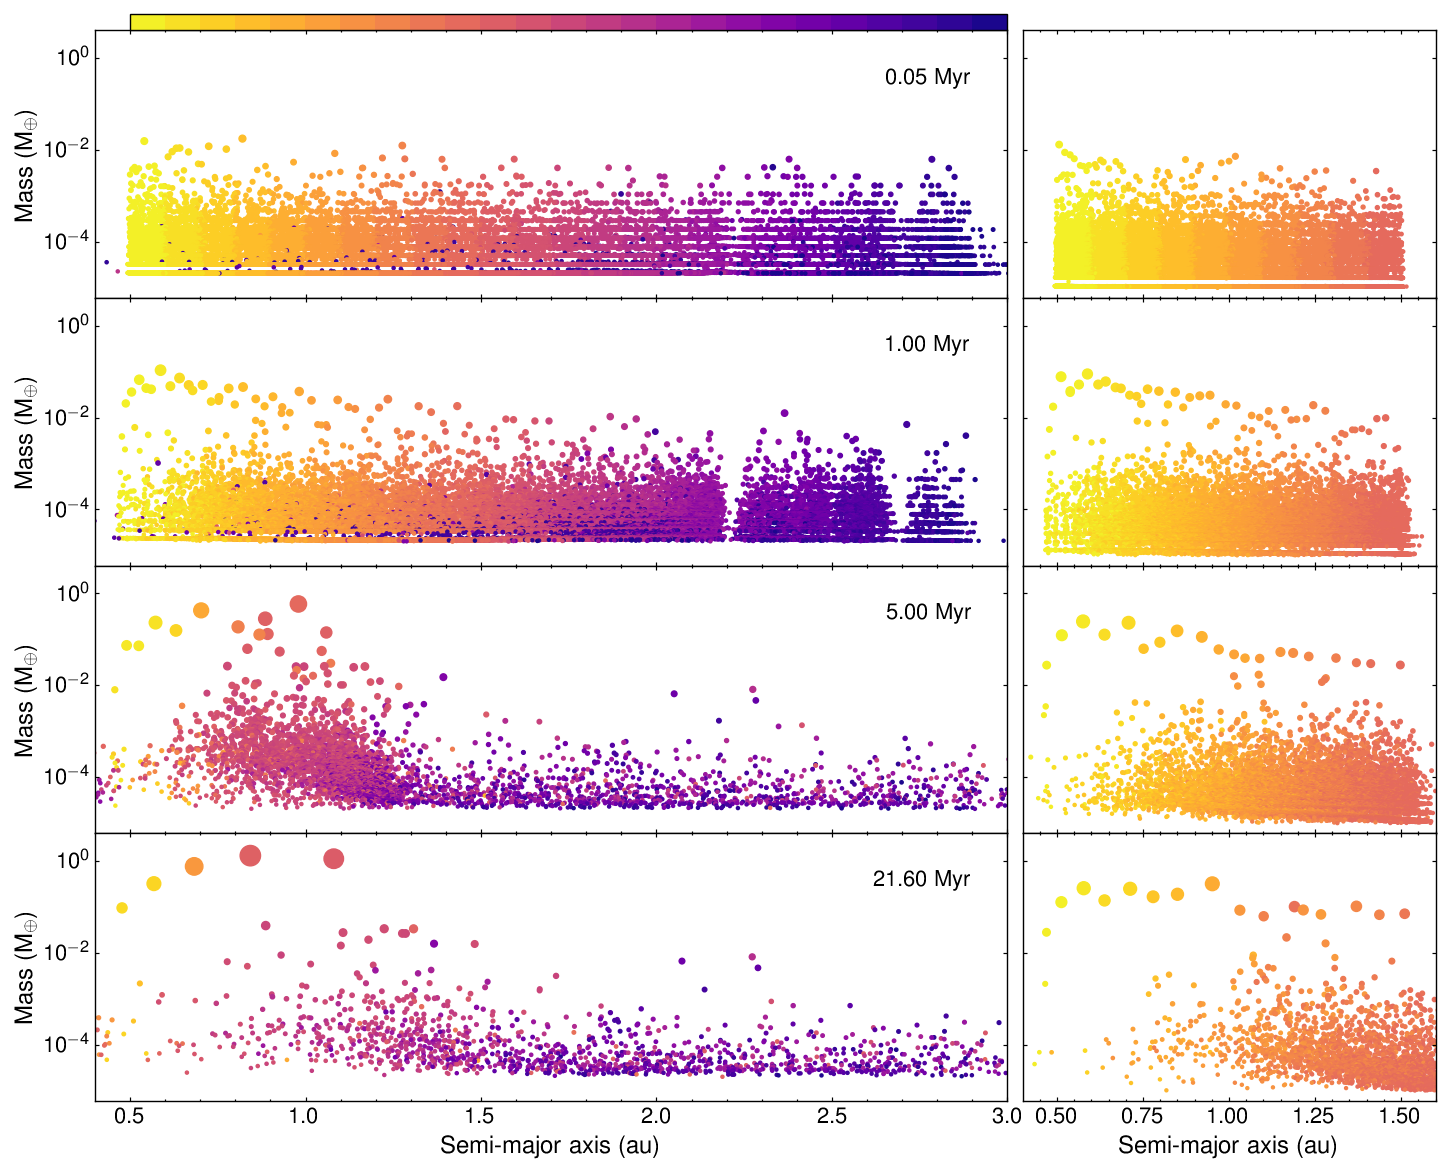

In [9]:
# mass vs semi-major axis with color and size

mncol = 19

pr = 0

pltfiles = ['ss.0000280000','ss.0005560000','ss.0027780000','ss.{:0>10d}'.format(int(paramG['nSteps']))]
mnrow = len(pltfiles)

fig = plt.figure(figsize=(10,8))
    
for fl in pltfiles:
    ssj = pkd.ss()
    ssj.read(loc+fl,extras=True)
    ssj.calcOE()
    sorderj = npy.argsort(ssj.m)[::-1]
    indj = sorderj[(ssj.a[sorderj]<3.5)*(ssj.e[sorderj]<1.)]

    ssk = pkd.ss()
    ssk.read(loc_c+fl,extras=True)
    ssk.calcOE()

    sorderk = npy.argsort(ssk.m)[::-1]
    indk = sorderk[(ssk.a[sorderk]<3.5)*(ssk.e[sorderk]<1.)]
    
    plt.subplot2grid((mnrow, mncol), (pr, 0),colspan=13)
    plt.minorticks_on()
    plt.scatter(ssj.a[indj],ssj.m[indj]/mearth,s=marksize(ssj.m[indj]),c=npy.dot(ssj.origin[indj],bina),cmap=cm,norm=cnorm,rasterized=True)
    if pr == 0:
        ax1 = plt.gca()
    plt.ylabel('Mass (M$_\oplus$)')
    if pr == mnrow-1:
        plt.xlabel('Semi-major axis (au)')
    plt.xlim(0.4,3.0)
    plt.ylim(6e-6,4e0)
    plt.semilogy()
    if pr < mnrow-1:
        plt.gca().set_xticklabels([])
    plt.text(0.96,0.8,'{:.2f}'.format(ssj.header.t*expfac**2/2./npy.pi/1e6,)+' Myr',ha='right',zorder=3,color='k',bbox=dict(facecolor='w',edgecolor='none',pad=0.4,alpha=0.6),transform=plt.gca().transAxes)

    
    plt.subplot2grid((mnrow, mncol), (pr, 13),colspan=6)
    plt.minorticks_on()
    plt.scatter(ssk.a[indk],ssk.m[indk]/mearth,s=marksize(ssk.m[indk]),c=npy.dot(ssk.origin[indk],bina[0:10]),cmap=cm,norm=cnorm,rasterized=True)
    #plt.ylabel('Mass')
    if pr == mnrow-1:
        plt.xlabel('Semi-major axis (au)')
    plt.xlim(0.4,1.6)
    plt.ylim(6e-6,4e0)
    plt.semilogy()
    if pr < mnrow-1:
        plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    
    pr += 1


plt.tight_layout(pad=0.2,w_pad=0.0,h_pad=0.0,rect=(0.006,0.001,0.999,0.988))

Bbox = matplotlib.transforms.Bbox.from_bounds(0.1/2.6, 1.0, 2.5/2.6, 0.06) #x0, y0, width, height)
trans = ax1.transAxes + fig.transFigure.inverted()
l, b, w, h = matplotlib.transforms.TransformedBbox(Bbox, trans).bounds

cax = plt.gcf().add_axes([l,b,w,h])
cb1 = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, norm=cnorm, orientation='horizontal',drawedges=False,ticks=[],boundaries=binedge)#, values=cnorm(bina[0:16]), boundaries=bina[0:16]

plt.show()


<b>Figure 2:</b> Mass distribution as a function of semi-major axis and time for bodies in a Grand Tack simulation (left, 022GTJf6hgas) and a calm accretion simulation (right, 022f6sgas\_4). The sizes of the points are scaled to the mass of each body. Colors indicate the mean origin distance of mass making up the body, with the corresponding initial colors shown in the bar above the top left panel. The evolution of the inner disk is very similar for the first two time panels, but after the tack (at 2\,Myr), the mass and composition (color) distribution in the Grand Tack scenario has substantially diverged from that in the calm accretion model.

### Composition

In this work, composition is used to refer to the distribution in original radial location of the materials accreted by a body (provenance). The simulations discussed here allow a more detailed comparison than the classical embryo 'feeding zone' analysis. We do not assign specific chemical or isotopic signatures to these radial bins, nor a chemical gradient across the disk. Naturally, chemical differences between regions of the disk is what we allude to, but without detailed knowledge of the original distribution we cannot meaningfully assign specific, detailed properties to radial bins. In the most general terms, bluer (purple and blue) material originates farther from the star and is likely, therefore, to be more volatile-rich than material from yellow and orange bins; but we impose no fixed model on this radial composition. %More specific chemical implications will be discussed in section \ref{s:discussion}.

As well as the full mass origin distribution or 'composition histogram' for a body, we can also calculate a mass-weighted mean color or mean origin distance for each body. These average colors are seen in Figures \ref{f:massdist}, \ref{f:embcompareGT}, and \ref{f:embcomparecalm} showing a clear difference in compositions and compositional similarities between the two example simulations. At the end of calm accretion simulations embryos generally have average colors (compositions) that correspond closely to their locations. In Grand Tack simulations most of the embryos (and planetesimals) are substantially 'bluer' due to the contribution of material shepherded inwards by Jupiter's migration.

The dynamically excited Grand Tack simulations produce Earth-like proto-planets with a mixture of material from across the inner solar system (see Figure \ref{f:ccexample}). This is a result of Jupiter's inward migration 'pushing' planetesimals from more distant parts of the inner disk into the Earth-forming region. As can be seen in Figures \ref{f:massdist} and \ref{f:embcompareGT}, there are multiple smaller embryos remaining at the end of these simulations, several of which have fairly similar compositions to the larger bodies. The calm accretion model produces embryos that are dominated by material originating close to their locations, resulting in a lower degree of similarity between the final embryos (Figure \ref{f:embcomparecalm}).

Figures \ref{f:embcompareGT} and \ref{f:embcomparecalm} reveal a wide range of planetesimal compositions at the end of these simulations. Embryos in the innermost regions of the disk have fewer planetesimals with similar compositions compared to embryos that formed closer to 1\,au. 

#### Planetesimal similarity comparison

In [10]:
nr = 3
nc = 2

def plntsmlsimilarity(e1=0,e2=1,e3=2):
    fig3 = plt.figure(figsize=(9,6.8))
    p = 1
    for k in [e1,e2,e3]:
        resarr = npy.zeros(indlenG)
        obbig = ssG.origin[indG[k]]

        for i in range(0,indlenG,1):
            res = npy.corrcoef(obbig,ssG.origin[indG[i]])
            resarr[i]=res[0,1]

        # correlation vs semi-major axis with color and size
        plt.subplot(nr,nc,p)
        plt.minorticks_on()
        plt.scatter(ssG.a[indG],resarr,s=marksize(ssG.m[indG]),c=npy.dot(ssG.origin[indG],bina),cmap=cm,norm=cnorm)
        plt.scatter(ssG.a[indG[k]],resarr[k],edgecolor='k',s=2.1*4*marksize(ssG.m[indG[k]])**0.7,facecolor='none',lw=1.0)
        plt.ylabel('Correlation\n Coefficient')
        plt.xlim(0.3,2.99)
        plt.ylim(ymax=1.2)
        if plt.gca().get_ylim()[0]>-0.5:
            plt.ylim(ymin=-0.5)
        if p < (nr-1)*nc:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('Semi-major axis (au)')
    
        # correlation vs mass with color and size
        plt.subplot(nr,nc,p+1)
        plt.minorticks_on()
        plt.scatter(ssG.m[indG]/mearth,resarr,s=marksize(ssG.m[indG]),c=npy.dot(ssG.origin[indG],bina),cmap=cm,norm=cnorm)
        plt.scatter(ssG.m[indG[k]]/mearth,resarr[k],edgecolor='k',s=2.1*4*marksize(ssG.m[indG[k]])**0.7,facecolor='none',lw=1.0)
        if abs(resarr[e2]-resarr[e3])<0.2:
            plt.text(ssG.m[indG[0]]/mearth*2.3,resarr[e1],str(e1),va='center',ha='center')
            plt.text(ssG.m[indG[0]]/mearth*2.7,resarr[e2],str(e2),va='center',ha='center')
            plt.text(ssG.m[indG[0]]/mearth*1.9,resarr[e3],str(e3),va='center',ha='center')
        else:
            for l in [e1,e2,e3]:
                plt.text(ssG.m[indG[0]]/mearth*2.3,resarr[l],str(l),va='center',ha='center')
        plt.semilogx()
        plt.xlim(8e-6,2e0)
        plt.ylim(ymax=1.2)
        if plt.gca().get_ylim()[0]>-0.5:
            plt.ylim(ymin=-0.5)
        plt.gca().set_yticklabels([])
        if p < (nr-1)*nc:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('Mass (M$_\oplus$)')
        
        p += 2

    plt.tight_layout(pad=0.3,w_pad=0,h_pad=0)
    fig3.canvas.draw()
    
w3 = widgets.interact(plntsmlsimilarity,e1=widgets.IntSlider(value=0,min=0,max=len(ssG.m[indG][ssG.m[indG]>=minembmass])-1,step=1,description='Embryo (1):',continuous_update=False),e2=widgets.IntSlider(value=1,min=0,max=len(ssG.m[indG][ssG.m[indG]>=minembmass])-1,step=1,description='Embryo (2):',continuous_update=False),e3=widgets.IntSlider(value=2,min=0,max=len(ssG.m[indG][ssG.m[indG]>=minembmass])-1,step=1,description='Embryo (3):',continuous_update=False));


interactive(children=(IntSlider(value=0, continuous_update=False, description='Embryo (1):', max=14), IntSlide…

<b>Figure 3:</b> Correlation of bodies to the three most massive embryos (highlighted and labelled in each row) at the end of an example Grand Tack simulation (022GTJf6hgas). The sizes of the points are scaled to the mass of each body. Colors indicate the mean origin distance of mass making up the body as in Figure 2.

In [11]:
nr = 3
nc = 2

def plntsmlsimilarityc(e1=0,e2=1,e3=2):
    fig4 = plt.figure(figsize=(9,6.8))
    p = 1
    for k in [e1,e2,e3]:
        resarr = npy.zeros(indlenc)
        obbig = ssc.origin[indc[k]]

        for i in range(0,indlenc,1):
            res = npy.corrcoef(obbig,ssc.origin[indc[i]])
            resarr[i]=res[0,1]

        # correlation vs semi-major axis with color and size
        plt.subplot(nr,nc,p)
        plt.minorticks_on()
        plt.scatter(ssc.a[indc],resarr,s=marksize(ssc.m[indc]),c=npy.dot(ssc.origin[indc],bina[0:10]),cmap=cm,norm=cnorm)
        plt.scatter(ssc.a[indc[k]],resarr[k],edgecolor='k',s=2.1*4*marksize(ssc.m[indc[k]])**0.7,facecolor='none',lw=1.0)
        plt.ylabel('Correlation\n Coefficient')
        plt.xlim(0.3,2.99)
        plt.ylim(ymax=1.2)
        if plt.gca().get_ylim()[0]>-0.5:
            plt.ylim(ymin=-0.5)
        if p < (nr-1)*nc:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('Semi-major axis (au)')
    
        # correlation vs mass with color and size
        plt.subplot(nr,nc,p+1)
        plt.minorticks_on()
        plt.scatter(ssc.m[indc]/mearth,resarr,s=marksize(ssc.m[indc]),c=npy.dot(ssc.origin[indc],bina[0:10]),cmap=cm,norm=cnorm)
        plt.scatter(ssc.m[indc[k]]/mearth,resarr[k],edgecolor='k',s=2.1*4*marksize(ssc.m[indc[k]])**0.7,facecolor='none',lw=1.0)
        if abs(resarr[e2]-resarr[e3])<0.2:
            plt.text(ssc.m[indc[0]]/mearth*2.3,resarr[e1],str(e1),va='center',ha='center')
            plt.text(ssc.m[indc[0]]/mearth*2.7,resarr[e2],str(e2),va='center',ha='center')
            plt.text(ssc.m[indc[0]]/mearth*1.9,resarr[e3],str(e3),va='center',ha='center')
        else:
            for l in [e1,e2,e3]:
                plt.text(ssc.m[indc[0]]/mearth*2.3,resarr[l],str(l),va='center',ha='center')
        plt.semilogx()
        plt.xlim(8e-6,2e0)
        plt.ylim(ymax=1.2)
        if plt.gca().get_ylim()[0]>-0.5:
            plt.ylim(ymin=-0.5)
        plt.gca().set_yticklabels([])
        if p < (nr-1)*nc:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel('Mass (M$_\oplus$)')
        
        p += 2

    plt.tight_layout(pad=0.3,w_pad=0,h_pad=0)
    fig4.canvas.draw()
    
w4 = widgets.interact(plntsmlsimilarityc,e1=widgets.IntSlider(value=0,min=0,max=len(ssc.m[indc][ssc.m[indc]>=minembmass])-1,step=1,description='Embryo (1):',continuous_update=False),e2=widgets.IntSlider(value=1,min=0,max=len(ssc.m[indc][ssc.m[indc]>=minembmass])-1,step=1,description='Embryo (2):',continuous_update=False),e3=widgets.IntSlider(value=2,min=0,max=len(ssc.m[indc][ssc.m[indc]>=minembmass])-1,step=1,description='Embryo (3):',continuous_update=False));


interactive(children=(IntSlider(value=0, continuous_update=False, description='Embryo (1):', max=17), IntSlide…

<b>Figure 4:</b> Correlation of bodies to the three most massive embryos (highlighted and labelled in each row) at the end of an example calm simulation (022f6sgas\_4). The sizes of the points are scaled to the mass of each body. Colors indicate the mean origin distance of mass making up the body as in Figure 2.

The numbers of similar bodies to each final embryo from all the simulations are shown in Figure \ref{f:nsimilar}. Each point in Figure \ref{f:nsimilar} represents an individual embryo, with the $y$-axis values showing the number of other embryos or planetesimals similar to it at the end of the simulation in which it formed. The top row shows the number of other embryos with a composition correlation coefficient of at least 0.5 for each embryo. The bottom row shows the numbers of planetesimals with a composition correlation coefficient of at least 0.5 for each embryo in the high resolution simulations. The choice of 0.5 is somewhat arbitrary; the distribution is similar with correlation cutoff between 0.2 and 0.7. The left-hand panels show embryos as a function of their final semi-major axis, the right-hand panels show the embryos as a function of their final mass. Orange points show embryos formed in the set of Grand Tack simulations and purple points show embryos from the calm accretion simulations. 

We see that there are typically greater numbers of similar embryos (5--8) for the larger embryos produced near 1\,au in the Grand Tack simulations. The most massive embryos in calm accretion simulations have already accreted much of the material with similar compositions, and so there are typically fewer similar embryos remaining at, and interior to, 1\,au. 

At the end of these Grand Tack simulations, there are several smaller embryos in the region close to 1\,au that are very similar in composition to the Earth-like proto-planets (Figures \ref{f:embcompareGT} and \ref{f:nsimilar}). It is expected that these embryos will be removed during the subsequent $\sim$100\,Myr via collision or ejection. One of these smaller embryos may represent Theia -- the body that collided with the proto-Earth leading to the formation of the Moon. The similar compositions of the proto-Earth and these smaller embryos suggest that Theia may have had a very similar stable isotope composition to the proto-Earth. Similar compositions for Theia and the proto-Earth would likely have resulted in an Earth and Moon with near-identical stable isotope compositions.

The numbers of planetesimals similar to embryos shown in Figure \ref{f:nsimilar} have noticeably distinct distributions compared to the numbers of similar embryos, with a very clear difference between the two evolution scenarios. For calm accretion the number of similar planetesimals to each embryo shows a clear and straightforward trend of increasing numbers of similar planetesimals with increasing semi-major axis. This reflects the inside-out evolution of the planetesimal disk. Closer to the star, where orbital timescales are shorter, embryos grow faster and accrete the majority of planetesimals from their feeding zone. At greater distances from the star accretion is slower and there are more planetesimals remaining. Without substantial mixing of the disk nearby planetesimals are very likely to be similar to embryos growing in the same region.

In the Grand Tack scenarios, inside of $\sim$0.8\,au planetesimals with similar compositions to the embryos have already been accreted by $\sim$5\,Myr, resulting in few planetesimals similar to embryos in the innermost regions of the disk (Figure \ref{f:nsimilar}). Jupiter's tack substantially mixes the disk, excites orbits, and concentrates planetesimal mass in an annulus between $\sim$0.8 and 1.3\,au. These effects of the Grand Tack, combined with collisional evolution, result in many planetesimals with similar compositions to the embryos remaining in this annulus region at 20\,Myr. The more rapid growth of embryos in the inner-most region of the disk, and the lower degree of mixing from Jupiter's migration, leave the 'Mercury' region very different to the Earth region of the disk. This inner-most part of the disk has fewer similar bodies, and compositions closer to the initial compositions of the annuli, similar to the calm accretion scenario. At larger distances from the star there is less mass left in the disk (fewer planetesimals and fewer embryos), leading to the decrease in numbers of planetesimals similar to embryos beyond $\sim$1.3\,au seen in Figure \ref{f:nsimilar}.

#### Number similar bodies

In [12]:

simsG = ['022GTJf6hgas/','022GTJf6hgas_2/','035GTJf6hgas/']#,'/cfGTlow/022GTJf6latehg/','/cfGTlow/022GTJf6hydrogasf/']
#,'/cfGTruns/022GTJf6nogas/'
#'/cfGTlow/022GTJf6nogas/'

simsc = ['022f6sgas_4/','022f6sgas_3/','035f6sgas/','035f6sgas_2/']
#,'/cfGTruns/022f6nogas/']
#'/cfGTlow/035f6nogas/'

pbar5 = widgets.IntProgress(min=0, max=8, description='Plotting...  ',bar_style='',layout=widgets.Layout(height='20px')) # instantiate the bar
display(pbar5) # display the bar


def nsimilars(cc=0.5):
    pbar5.value = 0
    narray = npy.array([])
    narrayp = npy.array([])
    aarray = npy.array([])
    marray = npy.array([])
    carray = npy.array([])
    narrayc = npy.array([])
    narraypc = npy.array([])
    aarrayc = npy.array([])
    marrayc = npy.array([])
    carrayc = npy.array([])

    j_low = 0         

    for sim in simsG:
        ssj = pkd.ss()
        paramj = pkd.readparam(path+sim+'ss.par')
        ssj.read(path+sim+'ss.{:0>10d}'.format(int(paramj['nSteps'])),extras=True)
        ssj.calcOE()
        sorderj = npy.argsort(ssj.m)[::-1]
        indj = sorderj[(ssj.a[sorderj]<3.5)*(ssj.e[sorderj]<1.)]
        indlenj = len(indj)

        narraytemp = npy.zeros(len(npy.where(ssj.m[indj]>=minembmass)[0]))
        narraytempp = npy.zeros(len(npy.where(ssj.m[indj]>=minembmass)[0]))
        aarraytemp = npy.zeros(len(narraytemp))
        marraytemp = npy.zeros(len(narraytemp))
        carraytemp = npy.zeros(len(narraytemp))

        for k in range(len(narraytemp)):
            resarr = npy.zeros(indlenj)
            obbig = ssj.origin[indj[k]]

            for i in range(0,indlenj,1):
              res = npy.corrcoef(obbig,ssj.origin[indj[i]])
              resarr[i]=res[0,1]
            narraytemp[k] = len(npy.where(resarr[ssj.m[indj]>=minembmass] >= cc)[0])#/float(indlenj)
            narraytempp[k] = len(npy.where(resarr[ssj.m[indj]<minembmass] >= cc)[0])#/float(indlenj)
            aarraytemp[k] = ssj.a[indj[k]]
            marraytemp[k] = ssj.m[indj[k]]
            carraytemp[k] = npy.dot(ssj.origin[indj[k]],bina)
        if sim!='022GTJf6hgas' and j_low == 0:
            j_low = len(narray)
        narray = npy.append(narray,narraytemp)
        narrayp = npy.append(narrayp,narraytempp)
        aarray = npy.append(aarray,aarraytemp)
        marray = npy.append(marray,marraytemp)
        carray = npy.append(carray,carraytemp)
        pbar5.value += 1
        
    if j_low==0:
        j_low=len(narrayp)
    
    
    for sim in simsc:
        ssj = pkd.ss()
        paramj = pkd.readparam(path+sim+'ss.par')
        ssj.read(path+sim+'ss.{:0>10d}'.format(int(paramj['nSteps'])),extras=True)
        ssj.calcOE()
        sorderj = npy.argsort(ssj.m)[::-1]
        indj = sorderj[(ssj.a[sorderj]<3.5)*(ssj.e[sorderj]<1.)]
        indlenj = len(indj)

        narraytemp = npy.zeros(len(npy.where(ssj.m[indj]>=minembmass)[0]))
        narraytempp = npy.zeros(len(npy.where(ssj.m[indj]>=minembmass)[0]))
        aarraytemp = npy.zeros(len(narraytemp))
        marraytemp = npy.zeros(len(narraytemp))
        carraytemp = npy.zeros(len(narraytemp))

        for k in range(len(narraytemp)):
            resarr = npy.zeros(indlenj)
            obbig = ssj.origin[indj[k]]

            for i in range(0,indlenj,1):
              res = npy.corrcoef(obbig,ssj.origin[indj[i]])
              resarr[i]=res[0,1]
            narraytemp[k] = len(npy.where(resarr[ssj.m[indj]>=minembmass] >= cc)[0])#/float(indlenj)
            narraytempp[k] = len(npy.where(resarr[ssj.m[indj]<minembmass] >= cc)[0])#/float(indlenj)
            aarraytemp[k] = ssj.a[indj[k]]
            marraytemp[k] = ssj.m[indj[k]]
            carraytemp[k] = npy.dot(ssj.origin[indj[k]],bina[0:10])

        narrayc = npy.append(narrayc,narraytemp)
        narraypc = npy.append(narraypc,narraytempp)
        aarrayc = npy.append(aarrayc,aarraytemp)
        marrayc = npy.append(marrayc,marraytemp)
        carrayc = npy.append(carrayc,carraytemp)

        pbar5.value += 1
    
    ### plot figure

    fig5 = plt.figure(figsize=(9,6))

    plt.subplot(221)
    plt.minorticks_on()
    plt.scatter(aarray,narray-1,s=marksize(marray),c='xkcd:tangerine',cmap=cm,norm=cnorm)
    plt.scatter(aarrayc,narrayc-1,s=marksize(marrayc),c='xkcd:purple',cmap=cm,norm=cnorm,zorder=0)
    plt.ylabel('Number similar embryos')
    plt.xlim(0.4,1.65)
    plt.gca().set_xticklabels([])

    plt.subplot(222)
    plt.minorticks_on()
    plt.scatter(marray/mearth,narray-1,s=marksize(marray),c='xkcd:tangerine',cmap=cm,norm=cnorm)
    plt.scatter(marrayc/mearth,narrayc-1,s=marksize(marrayc),c='xkcd:purple',cmap=cm,norm=cnorm,zorder=0)
    plt.semilogx()
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.xlim(8e-3,2)

    plt.subplot(223)
    plt.minorticks_on()
    plt.scatter(aarray[:j_low+1],narrayp[:j_low+1],s=marksize(marray[:j_low+1]),c='xkcd:tangerine',cmap=cm,norm=cnorm)
    plt.scatter(aarrayc,narraypc,s=marksize(marrayc),c='xkcd:purple',cmap=cm,norm=cnorm,zorder=0)
    plt.ylabel('Number similar planetesimals')
    plt.xlim(0.4,1.65)
    plt.xlabel('Semi-major axis (au)')
    plt.text(0.06,0.9,'Grand Tack',ha='left',zorder=3,color='xkcd:tangerine',transform=plt.gca().transAxes)
    plt.text(0.06,0.83,'calm accretion',ha='left',zorder=3,color='xkcd:purple',transform=plt.gca().transAxes)

    plt.subplot(224)
    plt.minorticks_on()
    plt.scatter(marray[:j_low+1]/mearth,narrayp[:j_low+1],s=marksize(marray[:j_low+1]),c='xkcd:tangerine',cmap=cm,norm=cnorm)
    plt.scatter(marrayc/mearth,narraypc,s=marksize(marrayc),c='xkcd:purple',cmap=cm,norm=cnorm,zorder=0)
    plt.semilogx()
    plt.gca().set_yticklabels([])
    plt.xlim(8e-3,2)
    plt.xlabel('Mass (M$_\oplus$)')

    plt.tight_layout(pad=0.3,w_pad=0,h_pad=0)

    #plt.savefig(path+'nsimilar.eps')
    fig5.canvas.draw()
    pbar5.value += 1

w5 = widgets.interact(nsimilars,cc=widgets.FloatSlider(value=0.5,min=-1,max=1.,step=0.05,description='Similar cut:',continuous_update=False));


IntProgress(value=0, description='Plotting...  ', layout=Layout(height='20px'), max=8)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Similar cut:', max=1.0, min…

<b>Figure 5:</b> Number of embryos (M$\geq$0.01$\,$M$_\oplus$) and planetesimals (M$<$0.01$\,$M$_\oplus$) with correlation coefficients greater than or equal to the cutoff for each embryo in several simulations. The numbers of similar bodies are shown as a function of semi-major axis (left) and mass (right). Orange points are for Grand Tack simulations, purple points are for calm accretion simulations. The sizes of the points are scaled to the mass of the embryos. Embryos from low resolution simulations are excluded from the planetesimal (lower) panels.

### Origins of similar planetesimals

We have seen that planetesimals with similar compositions to planetary embryos can be present in the disk early in the giant impact phase of evolution. We now examine the histories of these small bodies to learn how and why they are similar in composition to the embryos.

The time evolution of body compositions (Figures \ref{f:correlationevolutionGT} and \ref{f:correlationevolutioncalm}) allows us to examine when bodies become similar in composition to each other. The 12 most-similar final bodies for the two largest embryos from the example Grand Tack simulation (shown in Figure \ref{f:embcompareGT}) are shown in Figure \ref{f:correlationevolutionGT}. The thick dark purple line indicates the growing embryo itself. By definition, an embryo has its ending composition once it is fully grown, therefore its final correlation coefficient is 1.0. In both examples in Figure \ref{f:correlationevolutionGT}, the body that grew into the embryo (thick purple line) began with a correlation coefficient of 0.5 or less, indicating that the composition of the embryo changed substantially as it grew. The most massive embryo (upper panels) had several collisions with other embryos between 5 and 20\,Myr that significantly affected its composition. The second most massive embryo (lower panels) gained much of its compositional characteristics at $\sim$2\,Myr, during or shortly after Jupiter's migration event.

The majority of the most-similar planetesimals for the largest embryos in the Grand Tack (Figure \ref{f:correlationevolutionGT}) acquire their very-similar compositions at the time they form (appearing as vertical lines beginning on the x-axis in both panels); they are fragments ejected from the near-fully-grown planet. These fragments of proto-planets have typical masses ranging from ~5\% to a few times the mass of the modern asteroid belt. In the examples shown here, these surviving planetesimals can remain in the system for 10\,Myr or more as the planets continue growing. The most-similar bodies to the second largest embryo, shown in the lower panels of Figure \ref{f:correlationevolutionGT}, are closer in composition (higher correlation) at the end of the simulation run because the second largest embryo gains its final composition earlier than the most massive embryo (upper panels).

Embryos and planetesimals become compositionally similar early (in the first few Myr), as a result of collisions caused by the inward migration of Jupiter. There are thus many intermediate bodies (planetesimals and embryos) with similar compositions close to the tack point early in the giant impact phase (see Fig. \ref{f:embcompareGT}), and before the Moon-forming impact. One of these embryos could represent a Theia with isotopic composition similar to the proto-Earth. The final planets can have similar compositions to several intermediate embryos, and planetesimals could be ejected from any of these intermediate embryos.

#### Composition evolution

##### Grand Tack

In [13]:
def compevo(e=0,np=12):    
    resarr = npy.zeros(indlenG)

    fig6=plt.figure(figsize=(7,9.3))
    gs = matplotlib.gridspec.GridSpec(11, 2,wspace=0.32,bottom=0.32)
    fig6.add_subplot(gs[0:3,0])
    plt.minorticks_on()
    plt.bar(npy.arange(amin,amin+0.1*len(ssG.origin[indG[e]]),0.1),ssG.origin[indG[e]],width=0.1,color=cmap(cnorm(cval)),align='edge',edgecolor='k',lw=0.2)
    plt.xlabel('Semi-major axis (au)')
    plt.ylabel('Mass Fraction')
    if e==0:
        plt.text(0.03,1.18,'Most massive embryo',transform=plt.gca().transAxes)
    elif e==1:
        plt.text(0.03,1.18,'2nd most massive embryo',transform=plt.gca().transAxes)
    elif e==2:
        plt.text(0.03,1.18,'3rd most massive embryo',transform=plt.gca().transAxes)
    elif e>2:
        plt.text(0.03,1.18,'{:d}th most massive embryo'.format(e+1),transform=plt.gca().transAxes)
        
    
    obbig = ssG.origin[indG[e]]

    for i in range(0,indlenG,1):
        res = npy.corrcoef(obbig,ssG.origin[indG[i]])
        resarr[i]=res[0,1]

    # correlation vs mass with color and size
    fig6.add_subplot(gs[0:3,1])
    plt.minorticks_on()
    plt.scatter(ssG.m[indG]/mearth,resarr,s=0.45*marksize(ssG.m[indG]),c=npy.dot(ssG.origin[indG],bina[0:nbins]),cmap=cm,norm=cnorm)
    plt.scatter(ssG.m[indG[e]]/mearth,resarr[e],edgecolor='k',s=2.1*1.8*marksize(ssG.m[indG[e]])**0.7,facecolor='none',lw=1.2)
    plt.ylabel('Correlation')
    plt.xlabel('Mass (M$_\oplus$)')

    #plt.tight_layout(pad=0.2,w_pad=0.7,h_pad=0.)
    plt.semilogx()
    plt.ylim(ymax=1.1)

    
    fdata = npy.loadtxt(loc+'comp_evolution-{:d}.dat'.format(e),unpack=True)
    nbodies = int(( npy.shape(fdata)[0]-1)/2 ) 
    if nbodies>np+1:
        nbodies = np+1
    #print(nbodies)

    time = fdata[0]
    mt = fdata[1]
    cct = fdata[2]

    mlist = fdata[1::2]
    cclist = fdata[2::2]

    #fig6 = plt.figure(figsize=(5,4.6))
    gs2 = matplotlib.gridspec.GridSpec(11, 2)
    fig6.add_subplot(gs2[3:7,:])
    plt.minorticks_on()
    plt.plot(36*time/2./math.pi/1e6,cct,lw=1.0,color=cmalt(1.))
    for k in range(1,nbodies):
        if k % 3 == 1:#k>0.5*nbodies:
            ls='dashed'
        elif k % 3 == 2:#k>0.5*nbodies:
            ls='dashdot'
        else:
            ls='-'
        plt.plot(36*time/2./math.pi/1e6,cclist[k],ls=ls,lw=0.6,color=cmalt(1.-(1./(nbodies-1.))*k),zorder=nbodies-k)
    plt.ylabel('Correlation')
    plt.ylim(-0.6,1.05)
    plt.xlim(0,22)
    plt.gca().set_xticklabels([])
    
    gs3 = matplotlib.gridspec.GridSpec(11, 2)
    fig6.add_subplot(gs3[7:,:])
    plt.minorticks_on()
    plt.plot(36*time/2./math.pi/1e6,mt*330060,lw=1.0,color=cmalt(1.))#*330060)
    for k in range(1,nbodies):
        if k % 3 == 1:#k>0.5*nbodies:
            ls='dashed'
        elif k % 3 == 2:#k>0.5*nbodies:
            ls='dashdot'
        else:
            ls='-'
        plt.plot(36*time/2./math.pi/1e6,mlist[k]*330060,ls=ls,lw=0.6,color=cmalt(1.-(1./(nbodies-1.))*k),zorder=nbodies-k)#*330060)
    plt.semilogy()
    plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.,subs=(1.0,),numticks=9))
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.,subs=(0.2,0.4,0.6,0.8),numticks=9))
    plt.xlabel('Time (Myr)')
    plt.ylabel('Mass (M$_\oplus$)')
    plt.ylim(1e-5,2.)
    plt.xlim(0,22) #0,22

    #plt.tight_layout(h_pad=0.4,w_pad=0.5,pad=0.12)
    fig6.canvas.draw()
    #fig6a.canvas.draw()


w6 = widgets.interact(compevo,e=widgets.IntSlider(value=0,min=0,max=6,step=1,description='Embryo:',continuous_update=False),np=widgets.IntSlider(value=12,min=1,max=20,step=1,description='N similar:',continuous_update=False));


interactive(children=(IntSlider(value=0, continuous_update=False, description='Embryo:', max=6), IntSlider(val…

<b>Figure 6:</b> Evolution of composition correlation coefficient and body mass for the growing embryo and the 12 bodies with the most similar compositions at the end of an example Grand Tack simulation (022GTJf6hgas). The thick dark purple line indicates the embryo and the thin solid, dashed, and dot-dash lines the most similar bodies, colored in order of correlation coefficient (purple -- highest -- to yellow -- lowest).

There are several major differences in compositional evolution between the Grand Tack and calm accretion scenarios. Figure \ref{f:correlationevolutioncalm} shows the evolution of the two most massive embryos and the bodies most similar to them for an example calm accretion simulation. The embryos (thick dark purple lines) begin with compositions much more similar to their final compositions (correlation coefficients of $\sim$0.7 and 0.8) than seen for the Grand Tack example (Figure \ref{f:correlationevolutionGT}). With much less mixing than in the Grand Tack scenario, calm accretion results in embryos that are dominated by material that originated very close to their final locations.

The second clear difference in evolution of similar bodies in the calm accretion scenario is the origin of the most-similar smaller bodies. From Figure \ref{f:correlationevolutioncalm}, it is evident that most of these smaller bodies exist from the start of the simulation. Many of them evolve in composition very similarly to their similar embryo. Note, however, that many of the 'most-similar' bodies for the second largest embryo have low correlations to the embryos final composition. Of the 24 planetesimals most-similar to the two largest embryos in the example shown in Figure \ref{f:correlationevolutioncalm}, only one is a clear collision fragment -- the dot-dashed purple line appearing just before 8\,Myr in the upper panels. Unlike the compositionally similar fragments in the Grand Tack case, this fragment was not ejected from the embryo, it appeared with a correlation coefficient of $\sim$0.5, and only gained its greater similarity later.

##### Calm accretion

In [14]:

def compevoc(e=0,np=12):    
    resarr = npy.zeros(indlenc) # what is indlen!?

    fig7=plt.figure(figsize=(7,9.3))
    gs = matplotlib.gridspec.GridSpec(11, 2,wspace=0.32,bottom=0.32)
    fig7.add_subplot(gs[0:3,0])
    plt.minorticks_on()
    plt.bar(npy.arange(amin,amin+0.1*len(ssc.origin[indc[e]]),0.1),ssc.origin[indc[e]],width=0.1,color=cmap(cnorm(cval)),align='edge',edgecolor='k',lw=0.2)
    plt.xlabel('Semi-major axis (au)')
    plt.ylabel('Mass Fraction')
    if e==0:
        plt.text(0.03,1.18,'Most massive embryo',transform=plt.gca().transAxes)
    elif e==1:
        plt.text(0.03,1.18,'2nd most massive embryo',transform=plt.gca().transAxes)
    elif e==2:
        plt.text(0.03,1.18,'3rd most massive embryo',transform=plt.gca().transAxes)
    elif e>2:
        plt.text(0.03,1.18,'{:d}th most massive embryo'.format(e+1),transform=plt.gca().transAxes)
        
    
    obbig = ssc.origin[indc[e]]

    for i in range(0,indlenc,1):
        res = npy.corrcoef(obbig,ssc.origin[indc[i]])
        resarr[i]=res[0,1]

    # correlation vs mass with color and size
    fig7.add_subplot(gs[0:3,1])
    plt.minorticks_on()
    plt.scatter(ssc.m[indc]/mearth,resarr,s=0.45*marksize(ssc.m[indc]),c=npy.dot(ssc.origin[indc],bina[0:int(paramc['nDustBins'])]),cmap=cm,norm=cnorm)
    plt.scatter(ssc.m[indc[e]]/mearth,resarr[e],edgecolor='k',s=2.1*1.8*marksize(ssc.m[indc[e]])**0.7,facecolor='none',lw=1.2)
    plt.ylabel('Correlation')
    plt.xlabel('Mass (M$_\oplus$)')

    #plt.tight_layout(pad=0.2,w_pad=0.7,h_pad=0.)
    plt.semilogx()
    plt.ylim(ymax=1.1)

    
    fdata = npy.loadtxt(loc_c+'comp_evolution-{:d}.dat'.format(e),unpack=True)
    nbodies = int(( npy.shape(fdata)[0]-1)/2 ) 
    if nbodies>np+1:
        nbodies = np+1
    #print(nbodies)

    time = fdata[0]
    mt = fdata[1]
    cct = fdata[2]

    mlist = fdata[1::2]
    cclist = fdata[2::2]

    #fig6 = plt.figure(figsize=(5,4.6))
    gs2 = matplotlib.gridspec.GridSpec(11, 2)
    fig7.add_subplot(gs2[3:7,:])
    plt.minorticks_on()
    plt.plot(36*time/2./math.pi/1e6,cct,lw=1.0,color=cmalt(1.))
    for k in range(1,nbodies):
        if k % 3 == 1:#k>0.5*nbodies:
            ls='dashed'
        elif k % 3 == 2:#k>0.5*nbodies:
            ls='dashdot'
        else:
            ls='-'
        plt.plot(36*time/2./math.pi/1e6,cclist[k],ls=ls,lw=0.6,color=cmalt(1.-(1./(nbodies-1.))*k),zorder=nbodies-k)
    plt.ylabel('Correlation')
    plt.ylim(-0.6,1.05)
    plt.xlim(0,22)
    plt.gca().set_xticklabels([])
    
    gs3 = matplotlib.gridspec.GridSpec(11, 2)
    fig7.add_subplot(gs3[7:,:])
    plt.minorticks_on()
    plt.plot(36*time/2./math.pi/1e6,mt*330060,lw=1.0,color=cmalt(1.))#*330060)
    for k in range(1,nbodies):
        if k % 3 == 1:#k>0.5*nbodies:
            ls='dashed'
        elif k % 3 == 2:#k>0.5*nbodies:
            ls='dashdot'
        else:
            ls='-'
        plt.plot(36*time/2./math.pi/1e6,mlist[k]*330060,ls=ls,lw=0.6,color=cmalt(1.-(1./(nbodies-1.))*k),zorder=nbodies-k)#*330060)
    plt.semilogy()
    plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.,subs=(1.0,),numticks=9))
    plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.,subs=(0.2,0.4,0.6,0.8),numticks=9))
    plt.xlabel('Time (Myr)')
    plt.ylabel('Mass (M$_\oplus$)')
    plt.ylim(1e-5,2.)
    plt.xlim(0,22) #0,22

    #plt.tight_layout(h_pad=0.4,w_pad=0.5,pad=0.12)
    fig7.canvas.draw()
    

w7 = widgets.interact(compevoc,e=widgets.IntSlider(value=0,min=0,max=6,step=1,description='Embryo:',continuous_update=False),np=widgets.IntSlider(value=12,min=1,max=20,step=1,description='N similar:',continuous_update=False));


interactive(children=(IntSlider(value=0, continuous_update=False, description='Embryo:', max=6), IntSlider(val…

<b>Figure 7:</b> Evolution of composition correlation coefficient and body mass for the growing embryo and the 12 bodies with the most similar compositions at the end of an example calm accretion simulation (022f6sgas\_4). The thick dark purple line indicates the embryo and the thin solid, dashed, and dot-dash lines the most similar bodies, colored in order of correlation coefficient (purple -- highest -- to yellow -- lowest).

### Core composition

We assume that all bodies in these simulations are differentiated and remain differentiated throughout. Since these bodies can undergo imperfect collisions, the compositions of core and mantle can diverge. While this has a negligible effect on massive embryos, the planetesimals can develop substantial differences, particularly in the dynamically excited Grand Tack scenario  (see Figure \ref{f:corecomp}).

Approximately 9\% of bodies at the end of the Grand Tack simulations have correlation coefficients between their core and mantle compositions below 0.5.  
The calm accretion simulations also result in planetesimals with dissimilar core and mantle, but these represent a smaller fraction of the total number of bodies, $\sim$3\%.

For the planetesimals that have bulk compositions very similar to an embryo but have low core mass fractions the metallic core can have a substantially different composition distribution (see the upper rows in Figure \ref{f:corecomp}). In some cases the leftover planetesimals can have metallic cores similar to an embryo's composition, while the silicate mantle (or bulk composition) does not match.

This variation in core mass fraction and core and mantle compositions means that small bodies can have non-chondritic metal-silicate ratios, and siderophile elements from different isotopic reservoirs than the lithophiles.

#### Core

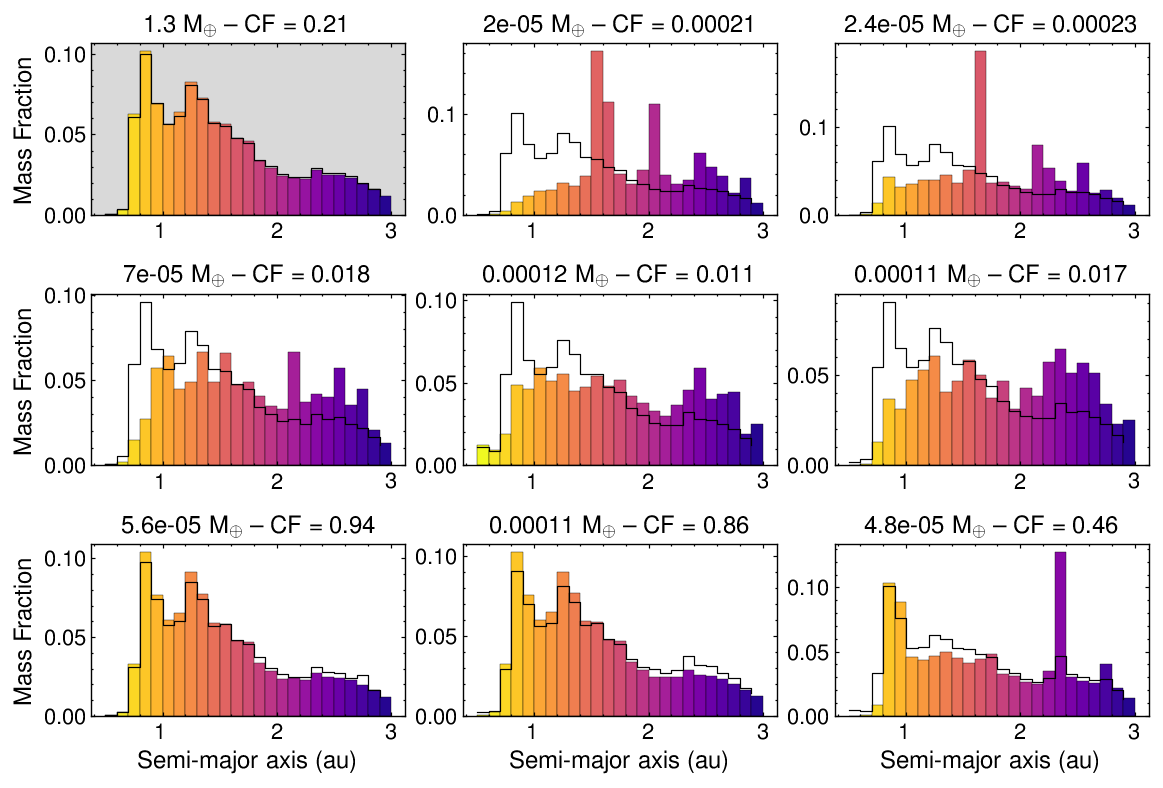

In [15]:
resarr = npy.zeros(indlenG)
resarrcore = npy.zeros(indlenG)

j=0

obbig = ssG.origin[indG[j]]

for i in range(0,indlenG,1):
    res = npy.corrcoef(obbig,ssG.origin[indG[i]])
    resarr[i]=res[0,1]
    res = npy.corrcoef(obbig,ssG.corigin[indG[i]])
    resarrcore[i]=res[0,1]


corder=npy.argsort(resarr)[::-1]

plt.figure(figsize=(8,5.4))

for i in range(0,9,1):
  plt.subplot(3,3,i+1)
  plt.minorticks_on()
  plt.step(npy.arange(amin,amin+0.1*len(ssG.origin[indG[i]]),0.1),ssG.origin[indG[corder[i]]],where='post',color='k',lw=0.6)
  plt.bar(npy.arange(amin,amin+0.1*len(ssG.corigin[indG[i]]),0.1),ssG.corigin[indG[corder[i]]],width=0.1,color=cmap(cnorm(cval)),align='edge',edgecolor='k',lw=0.2)
  #print(i, indG[corder[i]], ssG.a[indG[corder[i]]],ssG.e[indG[corder[i]]],ssG.m[indG[corder[i]]]*330060.,resarrcore[corder[i]])
  if i == 0:
    plt.gca().set_facecolor('0.85')
  if i>5:
        plt.xlabel('Semi-major axis (au)')
  if i in (0,3,6):
      plt.ylabel('Mass Fraction')
  plt.title('{:.2g} M$_\oplus$'.format(ssG.m[indG[corder[i]]]*330060)+'  –  CF = {:.2g}'.format(ssG.cf[indG[corder[i]]]),size=12)
  #ax.title.set_fontsize(30)

plt.tight_layout(pad=0.4,w_pad=0.5,h_pad=1.0)
#plt.savefig(loc+'histogramsc9-{:d}.png'.format(j))
#plt.savefig(loc+'histogramsc9-{:d}.pdf'.format(j))

plt.show()

<b>Figure 8:</b> Composition histograms for the most massive embryo (grey background) and the nine bodies with the most similar bulk compositions (with similarity decreasing left-to-right and top-to-bottom) at the end of a Grand Tack simulation (022GTJf6hgas). The black outline histogram shows the bulk composition distribution for each body and the colored bars show the corresponding core composition. The numbers above each panel give the mass and core mass fraction (CF) of each body.

## Discussion

We have seen that collisional evolution during the intermediate stages of terrestrial planet formation results in a range of planetesimal-sized bodies and small embryos with chemically similar compositions to the largest embryos. % early in the giant impact phase. 
Some of these planetesimals will be accreted or ejected from the terrestrial planet region before the final giant impact, but it is expected that some will survive and remain in the inner disk \citep[e.g.][]{OBrien06,Schlichting12}.

Most of these 'leftover' planetesimals are then expected to eventually be accreted by the terrestrial planets over the following billion years of evolution, or ejected from the solar system via dynamical interactions. A small fraction are likely scattered into the asteroid belt (Figure \ref{f:embcompareGT}), as has been suggested for iron-rich bodies \citep{Bottke06}, possibly becoming enstatite-like achondrites. However, we expect these 'planet fragments' to represent a small fraction of the total mass in the asteroid belt. Future work could use statistical evolution simulations to explore the delivery of these bodies to the asteroid belt.

Our results suggest that a portion of late accreted mass came from fragments of intermediate planetary embryos ejected earlier in the history of the solar system, rather than primitive chondritic planetesimals. These leftover bodies naturally have similar compositions to the planets. This leads us to a possible solution to the confounding origin of late accreted mass: it is leftover material that already matches the Earth in composition.

We have also seen that in dynamically excited planet formation scenarios, there can be several smaller planetary embryos near the proto-Earth with compositions similar to the proto-Earth during the early part of the giant impact phase (Figures \ref{f:embcompareGT} and \ref{f:nsimilar}). These embryos are potential Theias that would naturally have a similar stable isotopic composition to the proto-Earth before the Moon-forming impact. Even with significant variation in chemical and isotopic properties across the inner solar system, such a Theia would likely be sufficiently similar to alleviate some of the problems with the compositional similarity of the Earth and Moon \citep[e.g.][]{Dauphas14}. The similarity in stable isotopes (e.g.\ for oxygen) between the Earth and Moon would be expected if Theia was compositionally similar to the proto-Earth. However, the similarity in isotopic anomalies for Tungsten, which is substantially affected by core formation, likely requires a high degree of mixing in the giant impact in addition to similar impactor compositions \citep[e.g.][]{Lock18}.

As the simulations discussed in this work do not cover the entire giant impact phase, nor the final accretion of the leftover bodies, we cannot say which bodies survive until after the final giant impact on the Earth, or which are subsequently accreted. A large body of prior work on the giant impact stage and late accretion suggests that some significant portion of planetesimals survive, and that leftover small bodies are an important source of late accreted mass \citep[e.g.][]{Bottke10,Schlichting12,Fischer18,Brasser20}, though these models did not include the diversity of planetesimal compositions we see. Full numerical simulations of planet growth, including both runaway growth and giant impacts, are still prohibitively computationally expensive, but will be required to fully develop our understanding of terrestrial planet accretion.

As well as planetesimal-sized bodies with similar compositions, and a small number that are almost compositionally identical to the proto-Earth, there are also many dissimilar planetesimals left at the end of the simulations (Figure \ref{f:embcompareGT}). We expect some mixture of these planetesimal-sized bodies to be accreted by the proto-Earth. Typically the more-similar bodies are close in the disk to the proto-Earth, and the less-similar bodies are more distant. The dissimilar planetesimals are also, typically, in the outer, less evolved regions of the inner solar system and thus, likely to decrease in number as evolution of the disk continues. We therefore consider the more-similar planetesimals more likely to end up accreted by the proto-Earth than the less-similar bodies.

These simulations ignored planetesimals from the outer solar system (and the outer part of the inner solar system in the calm accretion case). While little outer solar system material is expected to be delivered to the inner disk in the calm accretion scenario, the migration of the giant planets in the Grand Tack model would have injected some outer solar system bodies into the Earth-formation region \citep[e.g.][]{Walsh11,Raymond17,CarterStewart20}. We expect this outer solar system material would have been mixed into the inner disk and the growing embryos similarly to the purple and blue material from the outer parts of the inner disk. The leftover collisionally processed planetesimals then likely incorporated some of this outer solar system material similarly to the proto-Earth. The fates of outer solar system planetesimals, and the delivery of these, likely more volatile-rich, bodies to the Earth-forming region of the disk should be explored in future work.

The simulations presented in this work ignored the generation of new planetesimals during the growth of planets. This simplification is applied near-universally in planet formation simulations. Improvements in our understanding of planetesimal formation, including recycling of collisionally-generated fragments, is needed in order to understand the effects on compositional evolution of terrestrial planets.

To ensure the simulations were computationally feasible we treated metallic cores and silicate mantles as separate, non-interacting components: there was no chemical equilibration between cores and mantles during accretion. This is a substantial simplification, particularly for smaller bodies that are less likely to have remained molten for long periods of time. We expect differentiation and (re-)equilibration in a real system would increase the compositional similarity between mantle and core for moderately siderophile/lithophile elements. This simplification is, however, of little concern when considering HSEs, which partition strongly into the metal phase. Even with substantial metal-silicate equilibration, HSEs are expected to reside in the cores of accreted bodies and act as if they were a non-interacting component. 

The HSE ruthenium has been the subject of several recent studies \citep[e.g.][]{Dauphas17,Bermingham18,Fischer-Godde20}. As Ru is highly siderophile it is expected that the majority of Ru in the accessible Earth was delivered via the late veneer. The Earth and the major chondrite groups appear to show a trend of increasingly s-process-depleted Ru (more negative $\varepsilon\,^{100}$Ru) with increasing heliocentric distance inferred for their formation \citep[e.g.][]{Fischer-Godde17}. The closest match to the Earth's Ru amongst known meteorites are the enstatite chondrites and IAB iron meteorites \citep{Bermingham18}. These Ru isotope anomalies suggested that the late veneer was largely derived from inner solar system material with similar isotopic composition to enstatite chondrites and the proto-Earth \citep[e.g.][]{Dauphas17,Fischer-Godde17}. Planetesimals or fragments from our simulations with compositions similar to the proto-Earth could naturally explain a late veneer with such an inner solar system isotopic signature. The compositional similarity between such late veneer impactors and the IAB and enstatite meteorites is sensitive to the relative timing, and order, of the formation of the parent bodies of these meteorites and the migration of the giant planets.

\citet{Fischer18Ru} explored ruthenium and molybdenum anomalies acquired by the terrestrial planets in $N$-body simulations using the perfect merging assumption. Differences in the duration of the simulations and the extent of the disk modeled preclude a direct comparison, but we can make some useful observations. In general terms we see similar trends, greater mixing and wider feeding zones in Grand Tack scenarios, and the requirement that the transition to 'outer solar system composition Ru' occurred at large distances from the Sun, such that the Earth acquires negligible Ru anomaly. It is possible that the compositionally similar collision fragments that we have found in our 'imperfect accretion' simulations help to reduce this requirement for distant Ru-composition-transition-location by providing a further source for late accretion with low or zero Ru anomaly. 

Recently, \citet{Fischer-Godde20} reported s-process-enriched Ru (with a positive $\varepsilon\,^{100}$Ru) present in rocks derived from early Archaean mantle ($\sim$3.8\,Gyr ago). This Ru isotopic signature reflects either preserved pre-late-veneer mantle or the composition of the early portion of late accretion. Mixing with an outer solar system, carbonaceous-chondrite-like component of the late veneer is favored in order to produce the Ru composition of the modern mantle \citep{Fischer-Godde20}. The compositions resulting from our simulations could be compatible with this new Ru data if the leftover planetesimals represent the early component of late accretion, a carbonaceous-chondrite-like component were delivered later, and the parent bodies of enstatite chondrites formed from material with a sufficiently larger mean heliocentric distance than the Earth ('bluer' material in Figures \ref{f:massdist} and \ref{f:correlationevolutionGT}) thus giving them an intermediate isotopic composition.


The simulations we examined in this work show that planetesimal-sized bodies that may survive to the end of the giant impact phase have a range of core mass fractions, and that cores and mantles of these bodies can have different compositions (radial origin distributions). This range of composition loosens the constraint on late veneer mass given by mantle HSEs. Bodies with metal-to-silicate ratios lower than chondritic would deliver fewer HSEs per unit mass than expected from bodies with chondritic compositions. Cores and mantles potentially having different compositions complicates the interpretation of the isotopic signatures of late accreted mass. Siderophile and lithophile elements delivered by any single body could possess isotopic signatures from different solar system reservoirs. Future simulations that consider only the giant impact phase of planet growth must consider the prior evolution of the small, planetesimal-sized bodies if the goal is to understand the compositions of the final planets.
We have seen that collisional evolution during the intermediate stages of terrestrial planet formation results in a range of planetesimal-sized bodies and small embryos with chemically similar compositions to the largest embryos. % early in the giant impact phase. 
Some of these planetesimals will be accreted or ejected from the terrestrial planet region before the final giant impact, but it is expected that some will survive and remain in the inner disk \citep[e.g.][]{OBrien06,Schlichting12}.

Most of these 'leftover' planetesimals are then expected to eventually be accreted by the terrestrial planets over the following billion years of evolution, or ejected from the solar system via dynamical interactions. A small fraction are likely scattered into the asteroid belt (Figure \ref{f:embcompareGT}), as has been suggested for iron-rich bodies \citep{Bottke06}, possibly becoming enstatite-like achondrites. However, we expect these 'planet fragments' to represent a small fraction of the total mass in the asteroid belt. Future work could use statistical evolution simulations to explore the delivery of these bodies to the asteroid belt.

Our results suggest that a portion of late accreted mass came from fragments of intermediate planetary embryos ejected earlier in the history of the solar system, rather than primitive chondritic planetesimals. These leftover bodies naturally have similar compositions to the planets. This leads us to a possible solution to the confounding origin of late accreted mass: it is leftover material that already matches the Earth in composition.

We have also seen that in dynamically excited planet formation scenarios, there can be several smaller planetary embryos near the proto-Earth with compositions similar to the proto-Earth during the early part of the giant impact phase (Figures \ref{f:embcompareGT} and \ref{f:nsimilar}). These embryos are potential Theias that would naturally have a similar stable isotopic composition to the proto-Earth before the Moon-forming impact. Even with significant variation in chemical and isotopic properties across the inner solar system, such a Theia would likely be sufficiently similar to alleviate some of the problems with the compositional similarity of the Earth and Moon \citep[e.g.][]{Dauphas14}. The similarity in stable isotopes (e.g.\ for oxygen) between the Earth and Moon would be expected if Theia was compositionally similar to the proto-Earth. However, the similarity in isotopic anomalies for Tungsten, which is substantially affected by core formation, likely requires a high degree of mixing in the giant impact in addition to similar impactor compositions \citep[e.g.][]{Lock18}.

As the simulations discussed in this work do not cover the entire giant impact phase, nor the final accretion of the leftover bodies, we cannot say which bodies survive until after the final giant impact on the Earth, or which are subsequently accreted. A large body of prior work on the giant impact stage and late accretion suggests that some significant portion of planetesimals survive, and that leftover small bodies are an important source of late accreted mass \citep[e.g.][]{Bottke10,Schlichting12,Fischer18,Brasser20}, though these models did not include the diversity of planetesimal compositions we see. Full numerical simulations of planet growth, including both runaway growth and giant impacts, are still prohibitively computationally expensive, but will be required to fully develop our understanding of terrestrial planet accretion.

As well as planetesimal-sized bodies with similar compositions, and a small number that are almost compositionally identical to the proto-Earth, there are also many dissimilar planetesimals left at the end of the simulations (Figure \ref{f:embcompareGT}). We expect some mixture of these planetesimal-sized bodies to be accreted by the proto-Earth. Typically the more-similar bodies are close in the disk to the proto-Earth, and the less-similar bodies are more distant. The dissimilar planetesimals are also, typically, in the outer, less evolved regions of the inner solar system and thus, likely to decrease in number as evolution of the disk continues. We therefore consider the more-similar planetesimals more likely to end up accreted by the proto-Earth than the less-similar bodies.

These simulations ignored planetesimals from the outer solar system (and the outer part of the inner solar system in the calm accretion case). While little outer solar system material is expected to be delivered to the inner disk in the calm accretion scenario, the migration of the giant planets in the Grand Tack model would have injected some outer solar system bodies into the Earth-formation region \citep[e.g.][]{Walsh11,Raymond17,CarterStewart20}. We expect this outer solar system material would have been mixed into the inner disk and the growing embryos similarly to the purple and blue material from the outer parts of the inner disk. The leftover collisionally processed planetesimals then likely incorporated some of this outer solar system material similarly to the proto-Earth. The fates of outer solar system planetesimals, and the delivery of these, likely more volatile-rich, bodies to the Earth-forming region of the disk should be explored in future work.

The simulations presented in this work ignored the generation of new planetesimals during the growth of planets. This simplification is applied near-universally in planet formation simulations. Improvements in our understanding of planetesimal formation, including recycling of collisionally-generated fragments, is needed in order to understand the effects on compositional evolution of terrestrial planets.

To ensure the simulations were computationally feasible we treated metallic cores and silicate mantles as separate, non-interacting components: there was no chemical equilibration between cores and mantles during accretion. This is a substantial simplification, particularly for smaller bodies that are less likely to have remained molten for long periods of time. We expect differentiation and (re-)equilibration in a real system would increase the compositional similarity between mantle and core for moderately siderophile/lithophile elements. This simplification is, however, of little concern when considering HSEs, which partition strongly into the metal phase. Even with substantial metal-silicate equilibration, HSEs are expected to reside in the cores of accreted bodies and act as if they were a non-interacting component. 

The HSE ruthenium has been the subject of several recent studies \citep[e.g.][]{Dauphas17,Bermingham18,Fischer-Godde20}. As Ru is highly siderophile it is expected that the majority of Ru in the accessible Earth was delivered via the late veneer. The Earth and the major chondrite groups appear to show a trend of increasingly s-process-depleted Ru (more negative $\varepsilon\,^{100}$Ru) with increasing heliocentric distance inferred for their formation \citep[e.g.][]{Fischer-Godde17}. The closest match to the Earth's Ru amongst known meteorites are the enstatite chondrites and IAB iron meteorites \citep{Bermingham18}. These Ru isotope anomalies suggested that the late veneer was largely derived from inner solar system material with similar isotopic composition to enstatite chondrites and the proto-Earth \citep[e.g.][]{Dauphas17,Fischer-Godde17}. Planetesimals or fragments from our simulations with compositions similar to the proto-Earth could naturally explain a late veneer with such an inner solar system isotopic signature. The compositional similarity between such late veneer impactors and the IAB and enstatite meteorites is sensitive to the relative timing, and order, of the formation of the parent bodies of these meteorites and the migration of the giant planets.

\citet{Fischer18Ru} explored ruthenium and molybdenum anomalies acquired by the terrestrial planets in $N$-body simulations using the perfect merging assumption. Differences in the duration of the simulations and the extent of the disk modeled preclude a direct comparison, but we can make some useful observations. In general terms we see similar trends, greater mixing and wider feeding zones in Grand Tack scenarios, and the requirement that the transition to 'outer solar system composition Ru' occurred at large distances from the Sun, such that the Earth acquires negligible Ru anomaly. It is possible that the compositionally similar collision fragments that we have found in our 'imperfect accretion' simulations help to reduce this requirement for distant Ru-composition-transition-location by providing a further source for late accretion with low or zero Ru anomaly. 

Recently, \citet{Fischer-Godde20} reported s-process-enriched Ru (with a positive $\varepsilon\,^{100}$Ru) present in rocks derived from early Archaean mantle ($\sim$3.8\,Gyr ago). This Ru isotopic signature reflects either preserved pre-late-veneer mantle or the composition of the early portion of late accretion. Mixing with an outer solar system, carbonaceous-chondrite-like component of the late veneer is favored in order to produce the Ru composition of the modern mantle \citep{Fischer-Godde20}. The compositions resulting from our simulations could be compatible with this new Ru data if the leftover planetesimals represent the early component of late accretion, a carbonaceous-chondrite-like component were delivered later, and the parent bodies of enstatite chondrites formed from material with a sufficiently larger mean heliocentric distance than the Earth ('bluer' material in Figures \ref{f:massdist} and \ref{f:correlationevolutionGT}) thus giving them an intermediate isotopic composition.


The simulations we examined in this work show that planetesimal-sized bodies that may survive to the end of the giant impact phase have a range of core mass fractions, and that cores and mantles of these bodies can have different compositions (radial origin distributions). This range of composition loosens the constraint on late veneer mass given by mantle HSEs. Bodies with metal-to-silicate ratios lower than chondritic would deliver fewer HSEs per unit mass than expected from bodies with chondritic compositions. Cores and mantles potentially having different compositions complicates the interpretation of the isotopic signatures of late accreted mass. Siderophile and lithophile elements delivered by any single body could possess isotopic signatures from different solar system reservoirs. Future simulations that consider only the giant impact phase of planet growth must consider the prior evolution of the small, planetesimal-sized bodies if the goal is to understand the compositions of the final planets.


## Summary

Planet formation simulations result in a population of planetesimals leftover from the early stages of accretion that are chemically similar to the proto-Earth. In dynamically excited scenarios, these bodies commonly originated as fragments of proto-planets ejected millions of years earlier. We find that dynamically excited planet formation models can result in a system of proto-planets and smaller embryos with very similar compositions. These similarities in composition suggest that Theia may have been isotopically similar to the proto-Earth if the protoplanetary disk was truncated and mixed via giant planet migration (or some other process).

Some of the planetesimal-sized bodies that exist during the early stages of the giant impact phase have large core mass fractions, with core compositions very similar to the proto-Earth. If these planetesimals are later accreted by the planet, they would represent late accreted mass with compositions that naturally match the composition of the Earth that can deliver HSEs to the mantle. The variation in core mass fraction and composition amongst these leftover bodies complicates the constraints on late accretion provided by HSEs. Models of the giant impact phase of planet growth must consider the earlier evolution of the small bodies in order to understand the compositional evolution of the Earth.

## Appendix

#### core similarity

In [16]:
simcut = 0.5

simsG = ['022GTJf6hgas/','022GTJf6hgas_2/','035GTJf6hgas/']#,'/cfGTlow/022GTJf6latehg/','/cfGTlow/022GTJf6hydrogasf/']
#,'/cfGTruns/022GTJf6nogas/'
#'/cfGTlow/022GTJf6nogas/'


simsc = ['022f6sgas_4/','022f6sgas_3/','035f6sgas/','035f6sgas_2/']
#,'/cfGTruns/022f6nogas/']
#'/cfGTlow/035f6nogas/'

rarray = npy.array([])
marray = npy.array([])
cfarray = npy.array([])
rarrayc = npy.array([])
marrayc = npy.array([])
cfarrayc = npy.array([])

j_low = 0         

for sim in simsG:
    ssj = pkd.ss()
    paramj = pkd.readparam(path+sim+'ss.par')
    ssj.read(path+sim+'ss.{:0>10d}'.format(int(paramj['nSteps'])),extras=True)
    ssj.calcOE()
    sorderj = npy.argsort(ssj.m)[::-1]
    indj = sorderj[(ssj.a[sorderj]<3.5)*(ssj.e[sorderj]<1.)]
    indlenj = len(indj)


    #for k in range(len(narraytemp)):
    resarr = npy.zeros(indlenj)
    
    for i in range(0,indlenj,1):
        mhist = (ssj.origin[indj[i]]-ssj.cf[indj[i]]*ssj.corigin[indj[i]])/(1-ssj.cf[indj[i]])
        res = npy.corrcoef(mhist,ssj.corigin[indj[i]])
        resarr[i]=res[0,1]
        
    if sim.count('low')>0 and j_low == 0:
         j_low = len(rarray)
    rarray = npy.append(rarray,resarr)
    marray = npy.append(marray,ssj.m[indj])
    cfarray = npy.append(cfarray,ssj.cf[indj])
print(rarray)
print(cfarray)
if j_low==0:
    j_low=len(rarray)

for sim in simsc:
    ssj = pkd.ss()
    paramj = pkd.readparam(path+sim+'ss.par')
    ssj.read(path+sim+'ss.{:0>10d}'.format(int(paramj['nSteps'])),extras=True)
    ssj.calcOE()
    sorderj = npy.argsort(ssj.m)[::-1]
    indj = sorderj[(ssj.a[sorderj]<3.5)*(ssj.e[sorderj]<1.)]
    indlenj = len(indj)

    resarr = npy.zeros(indlenj)
    for i in range(0,indlenj,1):
        mhist = (ssj.origin[indj[i]]-ssj.cf[indj[i]]*ssj.corigin[indj[i]])/(1-ssj.cf[indj[i]])
        res = npy.corrcoef(mhist,ssj.corigin[indj[i]])
        resarr[i]=res[0,1]
    
    rarrayc = npy.append(rarrayc,resarr)
    marrayc = npy.append(marrayc,ssj.m[indj])
    cfarrayc = npy.append(cfarrayc,ssj.cf[indj])
print(rarrayc)
print(cfarrayc)

<ipython-input-16-41bd6032d8dc>:35: RuntimeWarning: divide by zero encountered in true_divide
  mhist = (ssj.origin[indj[i]]-ssj.cf[indj[i]]*ssj.corigin[indj[i]])/(1-ssj.cf[indj[i]])
/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


[0.99911417 0.99943106 0.99965692 ... 0.99999969 0.9999755  0.99999985]
[0.21211099 0.22596468 0.20432679 ... 0.34957308 0.34722822 0.34956914]


<ipython-input-16-41bd6032d8dc>:60: RuntimeWarning: divide by zero encountered in true_divide
  mhist = (ssj.origin[indj[i]]-ssj.cf[indj[i]]*ssj.corigin[indj[i]])/(1-ssj.cf[indj[i]])


[0.9999352  0.99991652 0.99982014 ... 0.98654521 0.99962457 0.87075719]
[0.2175311  0.21967279 0.21703247 ... 0.39180287 0.37194164 0.99185857]


2353 203
0.63089713459539 0.5793063260978387
8929 327
0.77040208739019 0.0 0.99996844641603


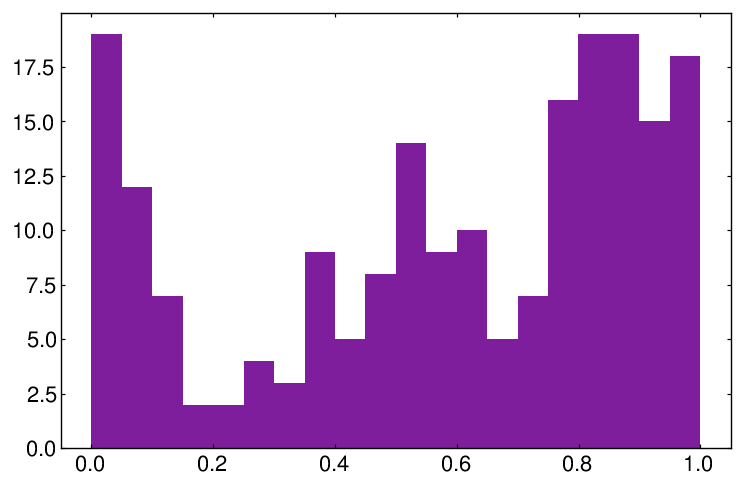

In [17]:
print(len(rarray),len(rarray[rarray<0.5]))
print(npy.median(cfarray[rarray<0.5]),cfarray[rarray<0.5].mean())

print(len(rarrayc),len(rarrayc[rarrayc<0.5]))
print(npy.median(cfarrayc[rarrayc<0.5]),cfarrayc[rarrayc<0.5].min(),cfarrayc[rarrayc<0.5].max())

plt.hist(cfarray[rarray<0.5],bins=20)
plt.show()

[1.00000000e-06 1.71132830e-06 2.92864456e-06 5.01187234e-06
 8.57695899e-06 1.46779927e-05 2.51188643e-05 4.29866235e-05
 7.35642254e-05 1.25892541e-04 2.15443469e-04 3.68694506e-04
 6.30957344e-04 1.07977516e-03 1.84784980e-03 3.16227766e-03
 5.41169527e-03 9.26118728e-03 1.58489319e-02 2.71227258e-02
 4.64158883e-02 7.94328235e-02 1.35935639e-01 2.32630507e-01
 3.98107171e-01 6.81292069e-01 1.16591440e+00 1.99526231e+00
 3.41454887e+00 5.84341413e+00 1.00000000e+01] [-1.         -0.93333333 -0.86666667 -0.8        -0.73333333 -0.66666667
 -0.6        -0.53333333 -0.46666667 -0.4        -0.33333333 -0.26666667
 -0.2        -0.13333333 -0.06666667  0.          0.06666667  0.13333333
  0.2         0.26666667  0.33333333  0.4         0.46666667  0.53333333
  0.6         0.66666667  0.73333333  0.8         0.86666667  0.93333333
  1.        ]


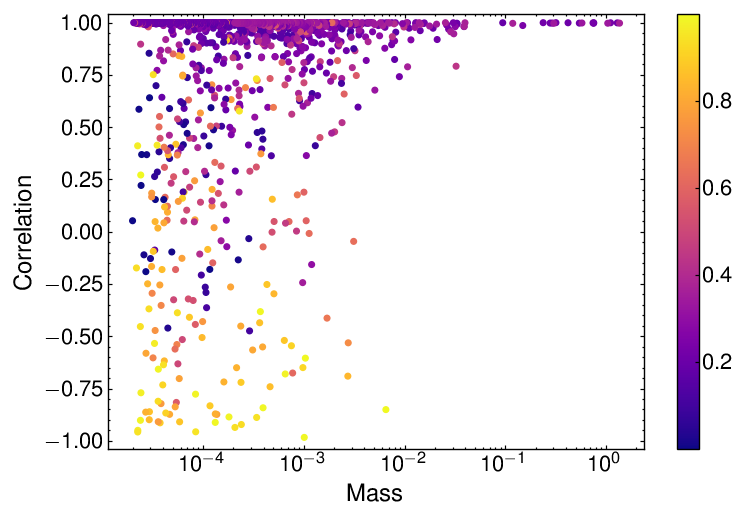

In [18]:
mbin = npy.logspace(-6,1.0,31)
ccbin = npy.linspace(-1.0,1.0,31)
print(mbin,ccbin)
#plt.hist2d(marray/mearth,rarray,bins=(mbin,ccbin),norm=LogNorm())
plt.scatter(marray/mearth,rarray,c=cfarray,s=8)
#plt.scatter(marrayc,rarrayc)
plt.semilogx()
plt.colorbar()
plt.ylim(-1.04,1.04)
plt.ylabel('Correlation')
plt.xlabel('Mass')
plt.minorticks_on()
plt.show()

#### Pie plots

In [19]:
ncols = 1680 #84  #columns for pie plot large to give higher distance resolution

if core:
    nrows = 480 #24  # rows for pie plot
else:
    nrows = 240 #12


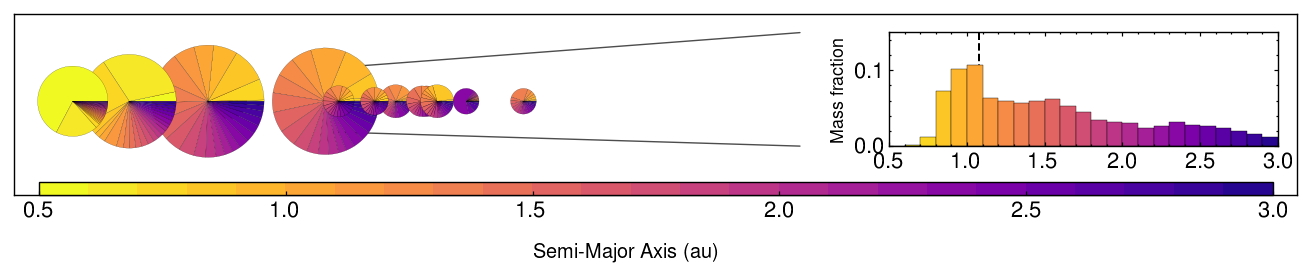

In [20]:
fig = plt.figure(figsize=(9,1.794))

plt.subplots_adjust(left=0.005,right=0.995,top=0.98,bottom=0.28)


big_plot = fig.add_subplot(111)
big_plot.set_xlim([axmin,axmax])
big_plot.set_ylim([0,1])
big_plot.axes.get_yaxis().set_visible(False)
big_plot.axes.get_xaxis().set_visible(False)
plt.minorticks_on()

if core:
    big_plot.text(1.7,0.76,r'Mantle')
    big_plot.text(1.7,0.28,r'Core')
    big_plot.text(amin+0.04*nbins,-0.16,r'Semi-Major Axis (au)')
else:
    big_plot.text(amin+0.04*nbins,-0.35,r'Semi-Major Axis (au)',fontsize=10)
#big_plot.set_ylabel('')
#big_plot.set_xticklabels('')

#cmap = ListedColormap(['#A30000','#FF0000','#FF8F00','#FFEC00','#8EFF00','#1EFF00','#06FFC6','#0093FF','#0000FF','#6053FF'])


if core:
    if nbins==10:
        ax = fig.add_axes([0.05, 0.15, 0.9, 0.05])#0.28
        tickstep=0.1
    if nbins==25:
        ax = fig.add_axes([0.024, 0.15, 0.952, 0.05])#0.28
        tickstep=0.5
else:
    if nbins==10:
        ax = fig.add_axes([0.05, 0.28, 0.9, 0.05])#0.28
        tickstep=0.1
    if nbins==25:
        ax = fig.add_axes([0.024, 0.28, 0.952, 0.05])#0.28
        tickstep=0.5
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=cnorm, values=cval, boundaries=npy.linspace(amin,amax,nbins+1), orientation='horizontal',drawedges=False,ticks=npy.arange(amin,amax+tickstep,tickstep))



planets = npy.where(ssG.m >= minembmass)[0]

ob = ssG.origin#[sorder]

a = ssG.a[planets]
r = ssG.r[planets]
hist = ob[planets,:] #:,
m = ssG.m[planets]

for i in range(len(a)):
  if a[i] < axmax and a[i] >= 0.5:
    piey=ncols*int(0.48*nrows)
    piex=1+int((a[i]-axmin)/(axmax-axmin)*(ncols-1))
    pier=r[i]*rscale
    fig.add_subplot(nrows,ncols,piex+piey)
    plt.pie(hist[i], colors=cmap(cnorm(cval)), radius=pier, wedgeprops={ 'linewidth' : 0.08 ,'edgecolor':'k'}, normalize=True)

    if i==pn:
        #print(len(hist[i]))
        insx=0.68
        insw=0.3
        insy=0.47
        insh=0.44
        ax2=fig.add_axes([insx,insy,insw,insh])
        ax2.bar(npy.arange(amin,amin+0.1*len(hist[i]),0.1),hist[i],width=0.1,color=cmap(cnorm(cval)),align='edge',edgecolor='k',lw=0.2)
        ax2.axvline(a[i],ls='--',color='k',zorder=0)
        ax2.set_ylabel('Mass fraction',fontsize=9)
        ax2.axis([0.5,3.0,0,hmax])
        #ax2.axes.get_xaxis().set_visible(False)
        ax2.minorticks_on()
        #ax2.set_xticklabels('')
        big_plot.annotate(text='',xy=(a[i],0.7),xytext=(2.05,0.9),xycoords='data',arrowprops=dict(arrowstyle='-',color='0.3'),zorder=0)
        big_plot.annotate(text='',xy=(a[i],0.35),xytext=(2.05,0.27),xycoords='data',arrowprops=dict(arrowstyle='-',color='0.3'),zorder=0)


plt.show()


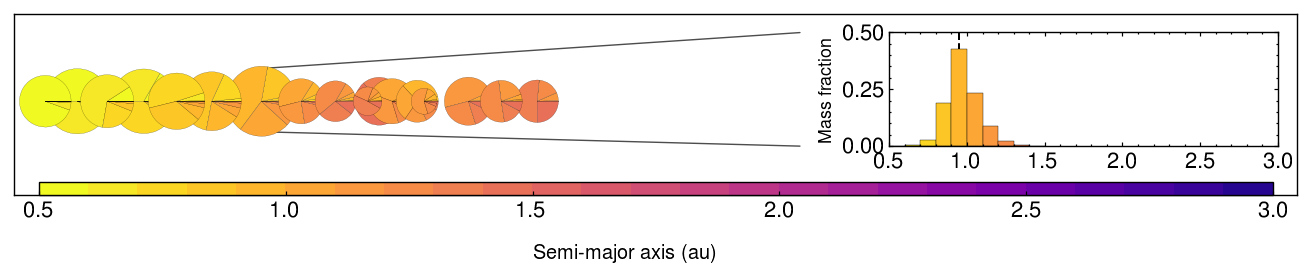

In [21]:
# calm accretion simulation

fig = plt.figure(figsize=(9,1.794))

plt.subplots_adjust(left=0.005,right=0.995,top=0.98,bottom=0.28)


big_plot = fig.add_subplot(111)
big_plot.set_xlim([axmin,axmax])
big_plot.set_ylim([0,1])
big_plot.axes.get_yaxis().set_visible(False)
big_plot.axes.get_xaxis().set_visible(False)
plt.minorticks_on()
#big_plot.set_xlabel(r'Semi-Major Axis', fontsize=16)
big_plot.text(amin+0.04*nbins,-0.35,r'Semi-major axis (au)',fontsize=10)
#big_plot.set_ylabel('')
#big_plot.set_xticklabels('')

#cmap = ListedColormap(['#A30000','#FF0000','#FF8F00','#FFEC00','#8EFF00','#1EFF00','#06FFC6','#0093FF','#0000FF','#6053FF'])

if nbins==10:
    ax = fig.add_axes([0.05, 0.28, 0.9, 0.05])#0.28
    tickstep=0.1
if nbins==25:
    ax = fig.add_axes([0.024, 0.28, 0.952, 0.05])#0.28
    tickstep=0.5
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=cnorm, values=cval, boundaries=npy.linspace(amin,amax,nbins+1), orientation='horizontal',drawedges=False,ticks=npy.arange(amin,amax+tickstep,tickstep))


paramc = pkd.readparam(loc_c+'ss.par')
ssc = pkd.ss()
ssc.read(loc_c+'ss.{:0>10d}'.format(int(paramc['nSteps'])),extras=True)
ssc.calcOE()
sorderc = npy.argsort(ssc.m)[::-1]
indc = sorderc[(ssc.a[sorderc]<3.5)*(ssc.e[sorderc]<1.)]
planets = npy.where(ssc.m[indc] >= minembmass)[0]


a = ssc.a[indc[planets]]
r = ssc.r[indc[planets]]
hist = (ssc.origin[indc])[planets,:] #:,
m = ssc.m[indc[planets]]


for i in range(len(a)):
  if a[i] < axmax and a[i] >= 0.5:
    piey=ncols*int(0.48*nrows)
    piex=1+int((a[i]-axmin)/(axmax-axmin)*(ncols-1))
    pier=r[i]*rscale
    fig.add_subplot(nrows,ncols,piex+piey)
    plt.pie(hist[i], colors=cmap(cnorm(cval)), radius=pier, wedgeprops={ 'linewidth' : 0.08 ,'edgecolor':'k'}, normalize=True)
    if i==pnc:
        #print(len(hist[i]))
        insx=0.68
        insw=0.3
        insy=0.47
        insh=0.44
        ax2=fig.add_axes([insx,insy,insw,insh])
        ax2.bar(npy.arange(amin,amin+0.1*len(hist[i]),0.1),hist[i],width=0.1,color=cmap(cnorm(cval)),align='edge',edgecolor='k',lw=0.2)
        ax2.axvline(a[i],ls='--',color='k',zorder=0)
        ax2.set_ylabel('Mass fraction',fontsize=9)
        ax2.axis([0.5,3.0,0,0.5])#hmax
        #ax2.axes.get_xaxis().set_visible(False)
        ax2.minorticks_on()
        #ax2.set_xticklabels('')
        big_plot.annotate(text='',xy=(a[i],0.7),xytext=(2.05,0.9),xycoords='data',arrowprops=dict(arrowstyle='-',color='0.3'),zorder=0)
        big_plot.annotate(text='',xy=(a[i],0.35),xytext=(2.05,0.27),xycoords='data',arrowprops=dict(arrowstyle='-',color='0.3'),zorder=0)


#plt.tight_layout()
plt.show()


## Acknowledgements

PJC and STS acknowledge financial support from the Simons Foundation. 
This research has made use of NASA's Astrophysics Data System.